In [37]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform

data_test = data
data = data[(data.index.month >= 1) & (data.index.month <= 11)]
X = data[features_columns]
y = data[target_column]
tss_rf = TimeSeriesSplit(n_splits=4)
X = data[features_columns]
y = data[target_column]
param_distributions_rf = {
    'randomforestregressor__n_estimators': randint(100, 1000),
    'randomforestregressor__max_depth': randint(3, 20),
    'randomforestregressor__min_samples_split': randint(2, 20),
    'randomforestregressor__min_samples_leaf': randint(1, 20),
    'randomforestregressor__max_features': uniform(0.1, 0.9)
}

rf_model = RandomForestRegressor(random_state=42)

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  
    ('randomforestregressor', rf_model)
])

random_search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_distributions_rf,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=tss_rf,
    random_state=2,
    verbose=1,
    return_train_score=True
)

random_search_rf.fit(X, y)
best_params_rf = random_search_rf.best_params_
print("Best Parameters:", best_params_rf)
best_rf_model = random_search_rf.best_estimator_


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best Parameters: {'randomforestregressor__max_depth': 12, 'randomforestregressor__max_features': 0.2460687386520825, 'randomforestregressor__min_samples_leaf': 15, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 655}


In [38]:
results = {
    'train_rmse': [],
    'test_rmse': [],
    'train_mae': [],
    'test_mae': []
}

for fold, (train_idx, test_idx) in enumerate(tss_rf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_train_pred = best_rf_model.predict(X_train)
    y_test_pred = best_rf_model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results['train_rmse'].append(train_rmse)
    results['test_rmse'].append(test_rmse)
    results['train_mae'].append(train_mae)
    results['test_mae'].append(test_mae)

    print(f"Fold {fold+1}: Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")


overall_results = {
    'train_rmse': np.mean(results['train_rmse']),
    'test_rmse': np.mean(results['test_rmse']),
    'train_mae': np.mean(results['train_mae']),
    'test_mae': np.mean(results['test_mae'])
}
print("Overall CV Results:", overall_results)

Fold 1: Train RMSE: 14.9106, Test RMSE: 13.5319, Train MAE: 11.3528, Test MAE: 9.7439
Fold 2: Train RMSE: 14.2380, Test RMSE: 13.5732, Train MAE: 10.5484, Test MAE: 9.8651
Fold 3: Train RMSE: 14.0199, Test RMSE: 13.1146, Train MAE: 10.3206, Test MAE: 9.5041
Fold 4: Train RMSE: 13.7991, Test RMSE: 13.1050, Train MAE: 10.1165, Test MAE: 9.3891
Overall CV Results: {'train_rmse': 14.241898171283717, 'test_rmse': 13.331147099613702, 'train_mae': 10.584587698812637, 'test_mae': 9.625566061522136}


## For forecast - For 1 day

In [68]:
data_test_day = data_test[(data_test.index.month==12) & (data_test.index.day==1)]
X_test_day = data_test_day[features_columns]
y_test_day = data_test_day[target_column]
y_test_day_pred = random_search_rf.best_estimator_.predict(X_test_day)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


test_rmse = np.sqrt(mean_squared_error(y_test_day, y_test_day_pred))
test_mae = mean_absolute_error(y_test_day, y_test_day_pred)
test_mape = np.mean(np.abs((y_test_day - y_test_day_pred) / y_test_day)) * 100

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}")


Test RMSE: 13.807487893446941
Test MAE: 9.457045579685836
Test MAPE: 30.90407359394814


C:\Users\DELL\AppData\Local\Temp\ipykernel_27168\3807675241.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_day['hour'] = data_test_day.index.hour


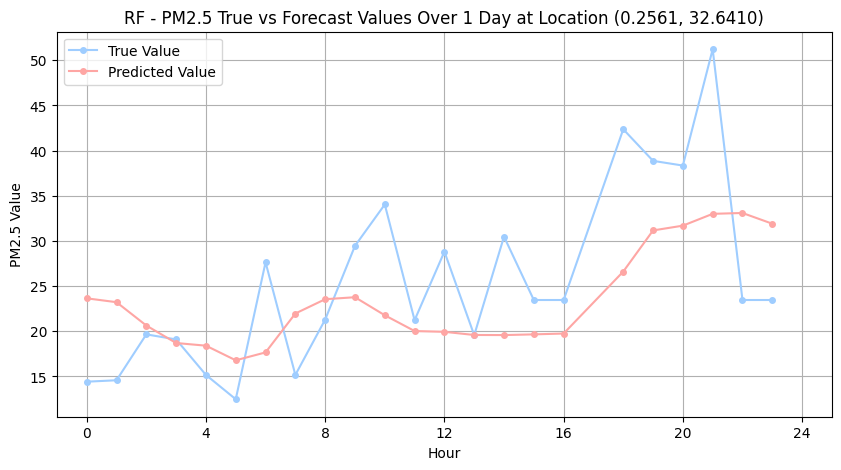

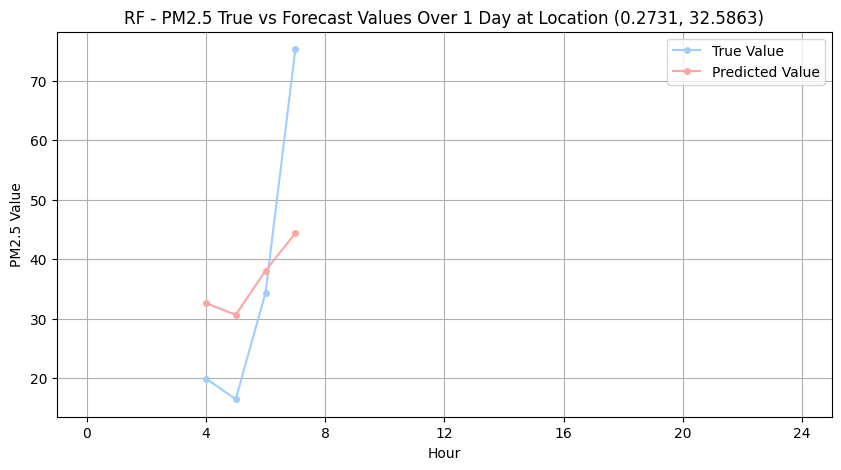

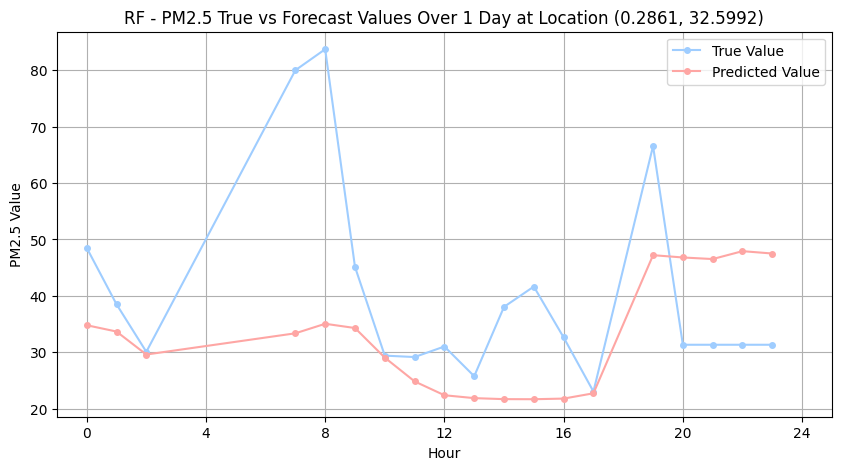

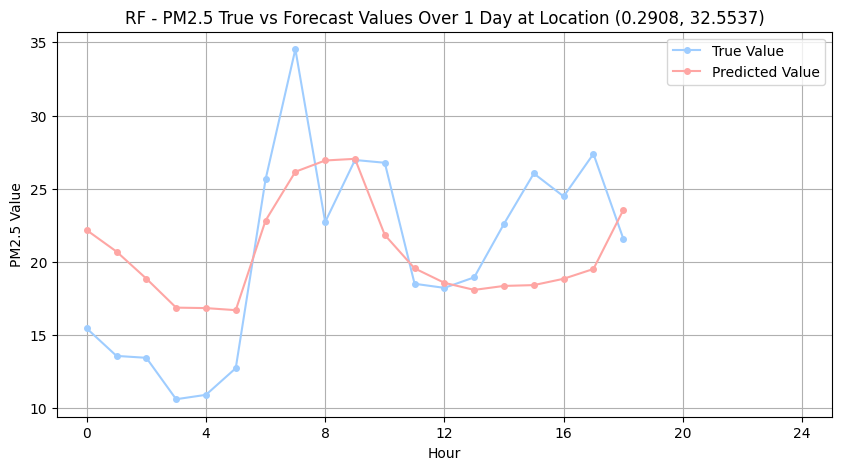

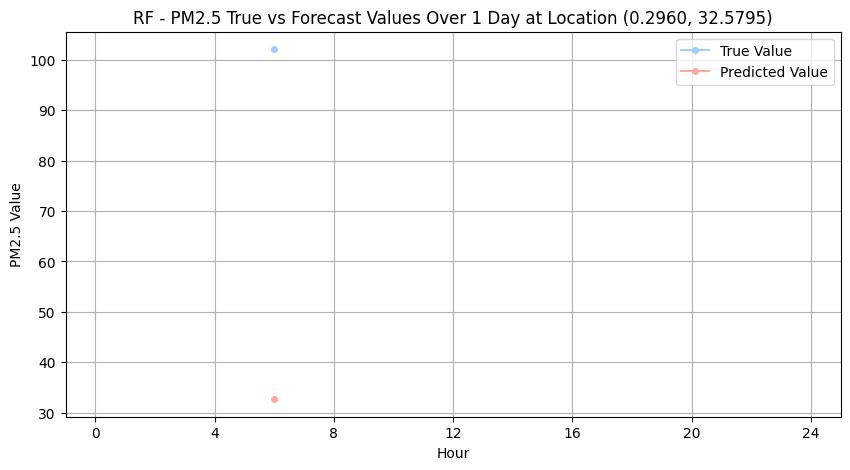

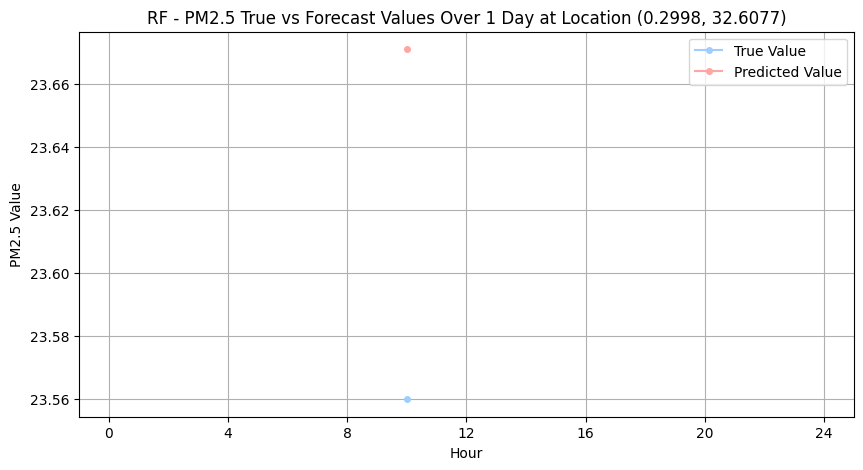

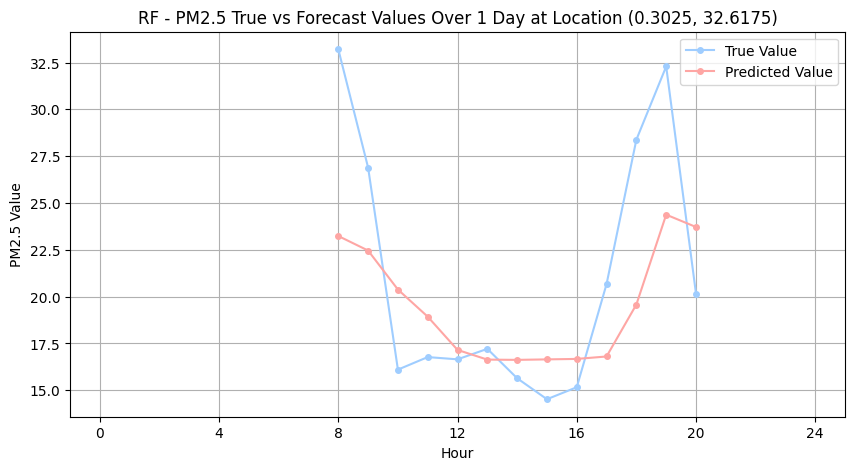

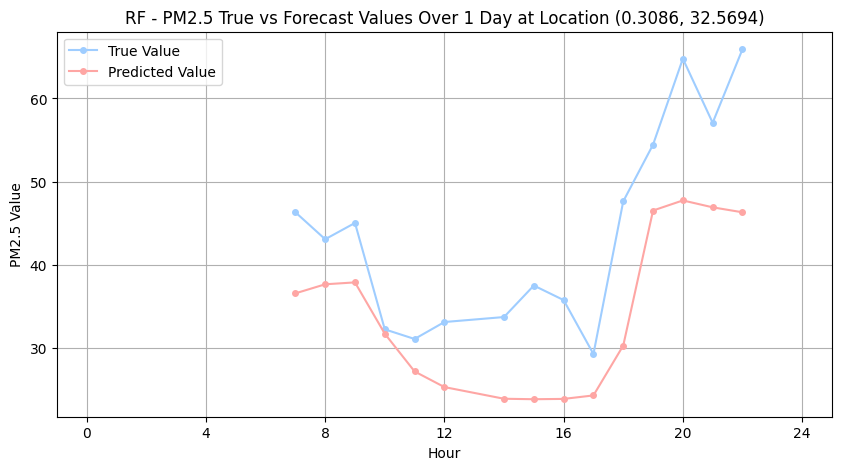

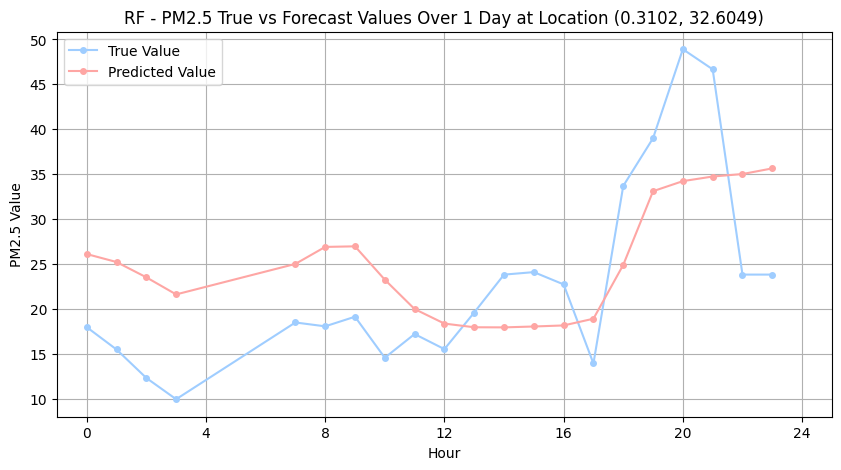

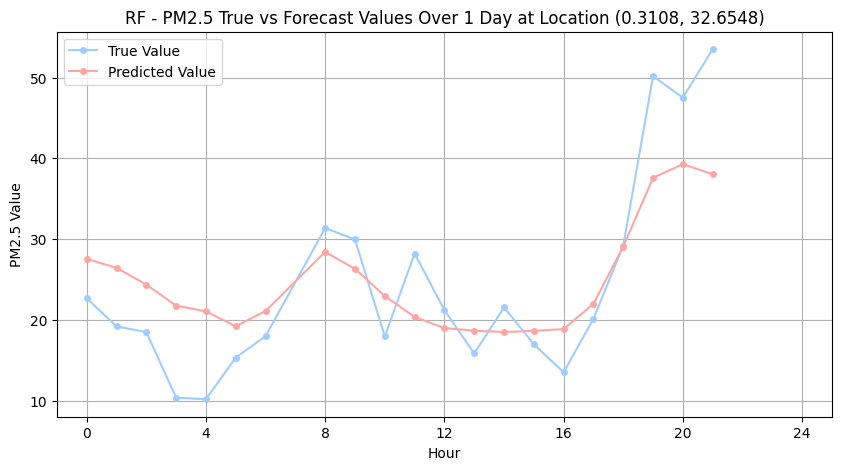

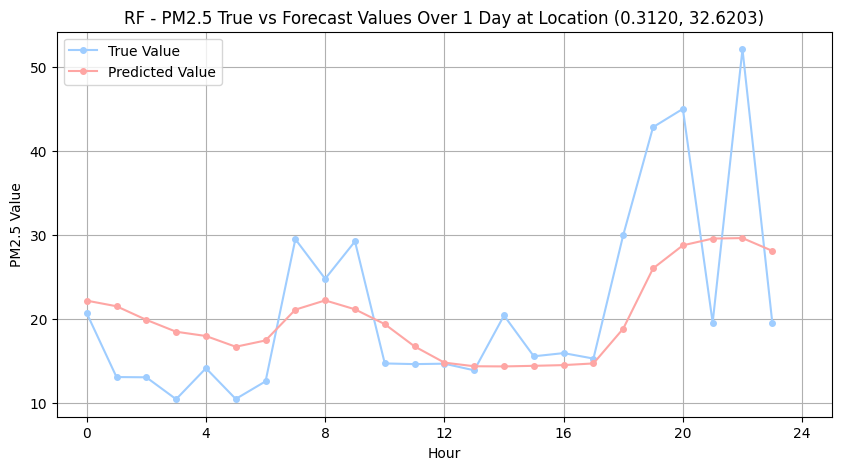

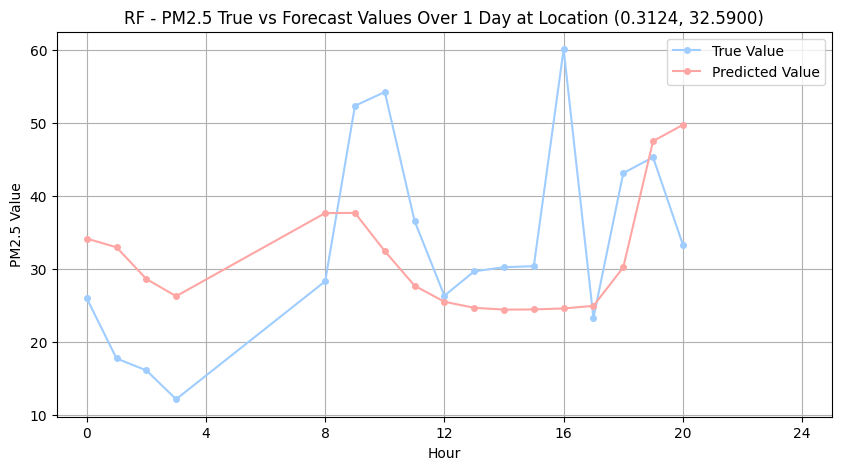

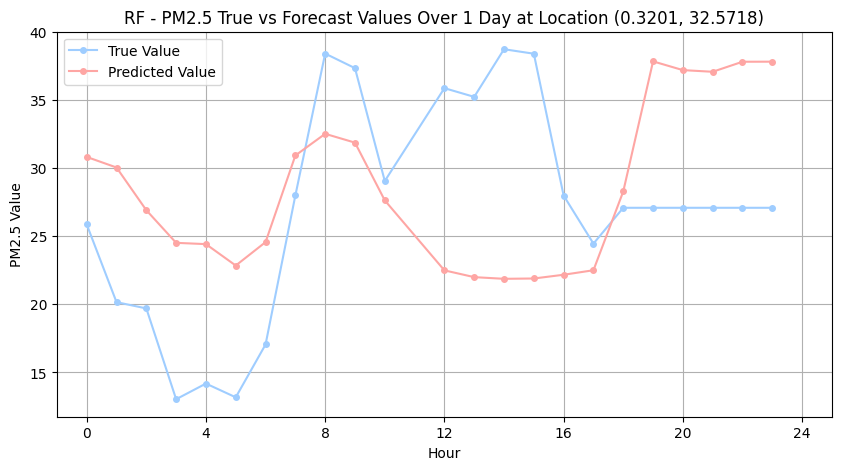

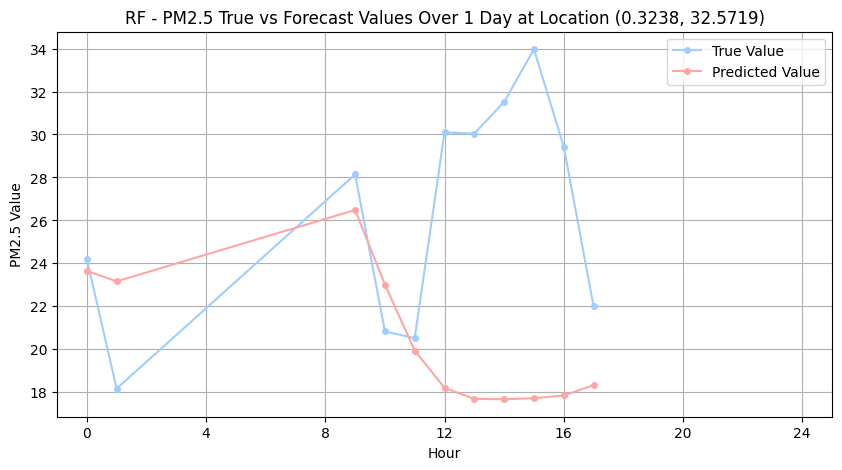

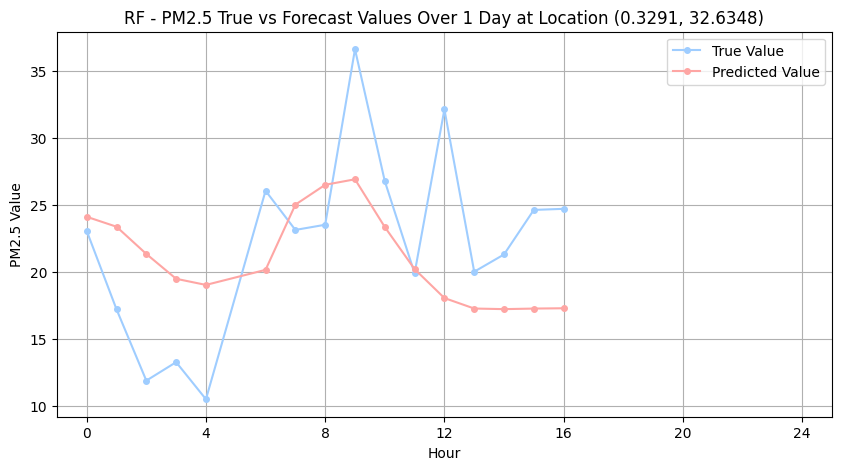

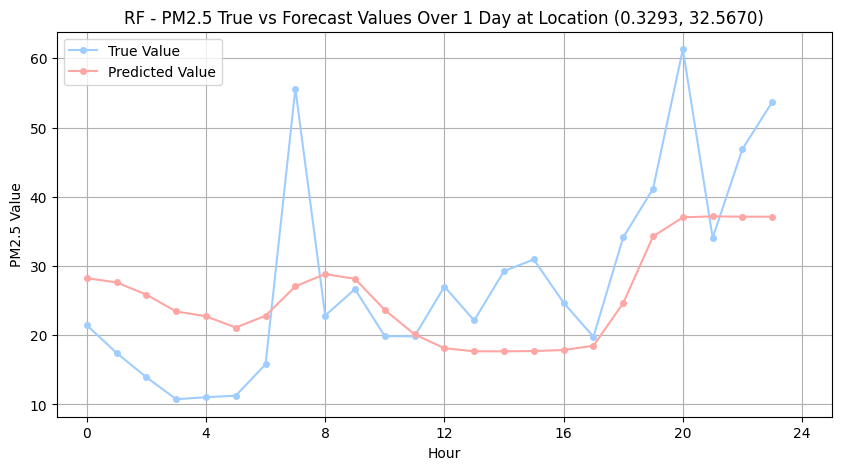

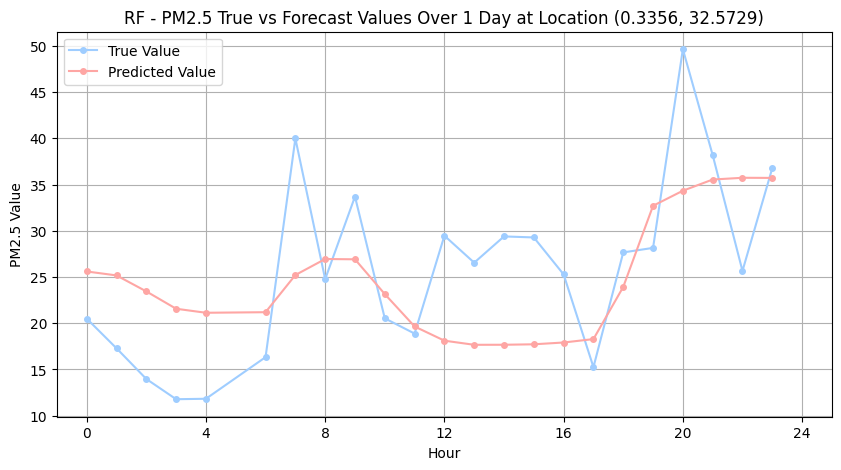

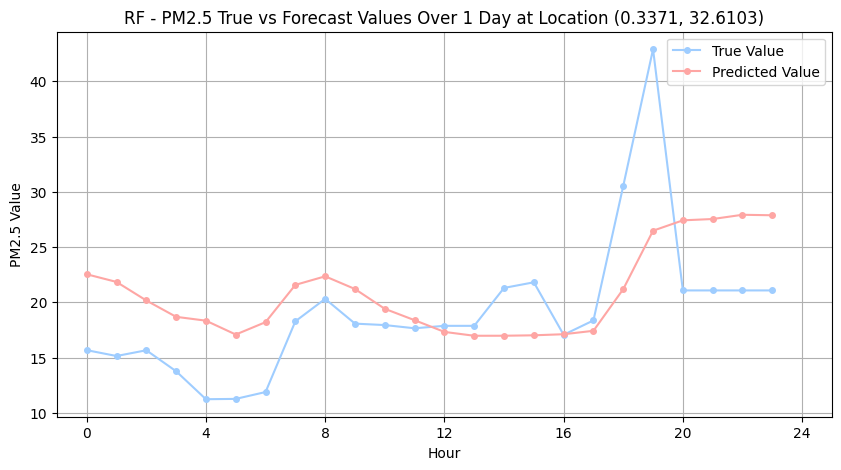

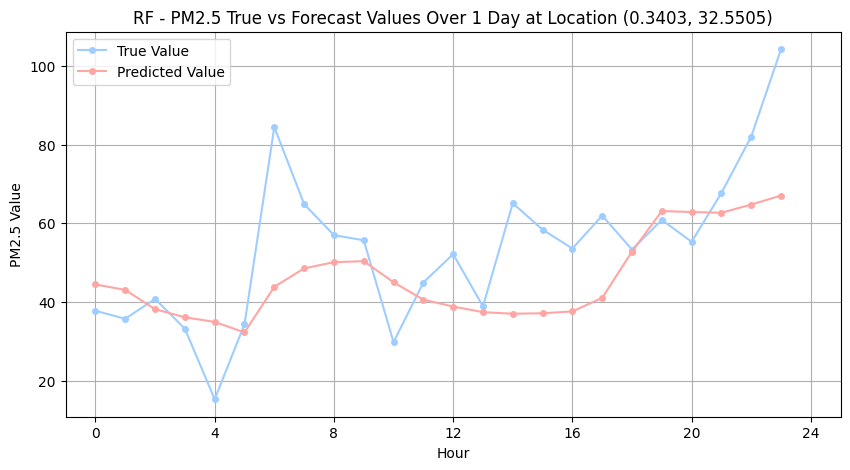

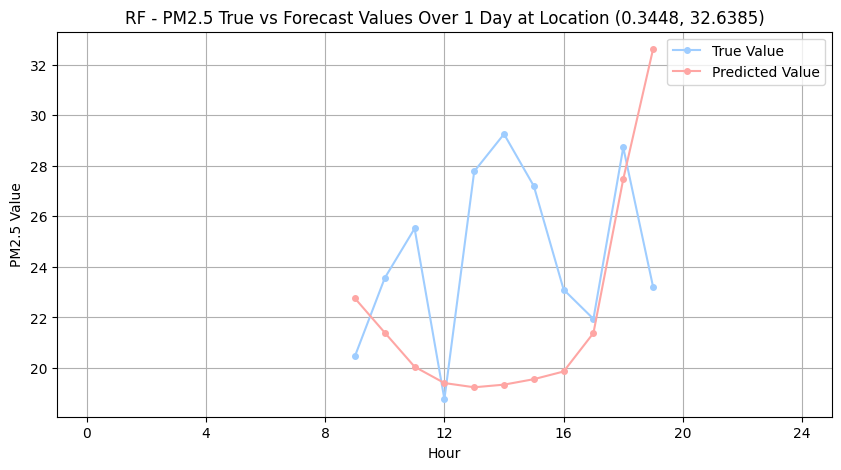

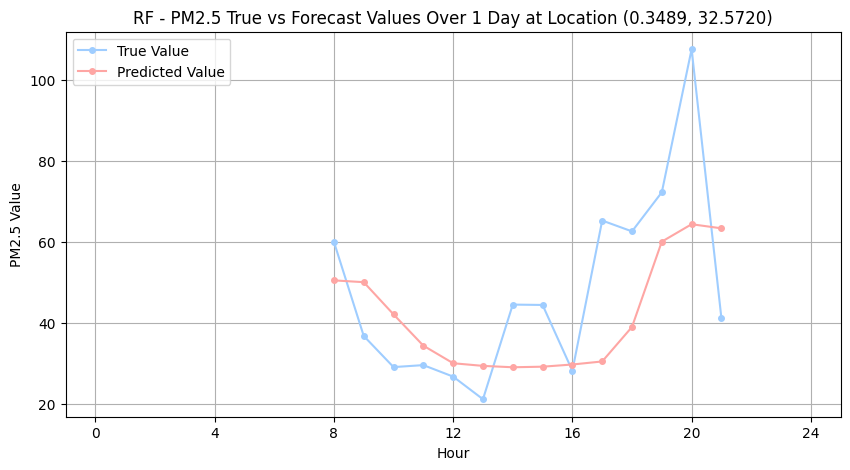

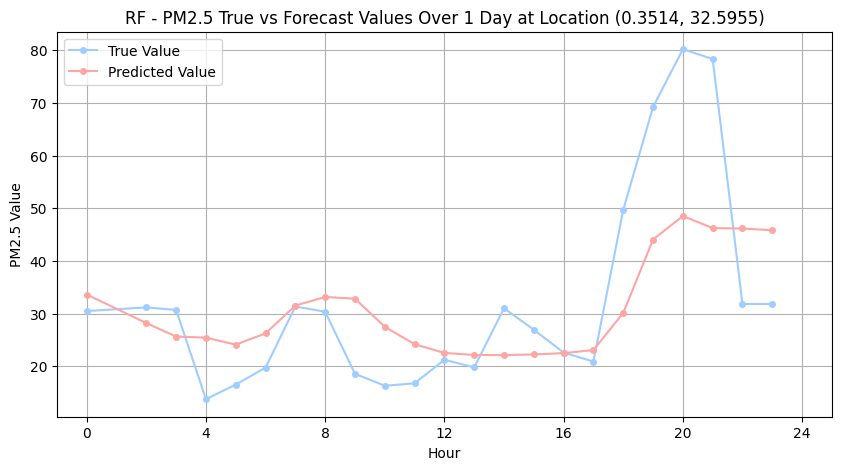

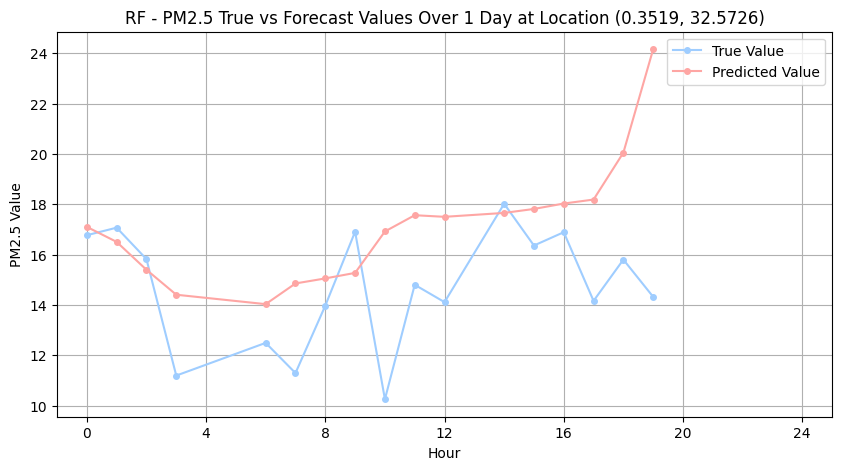

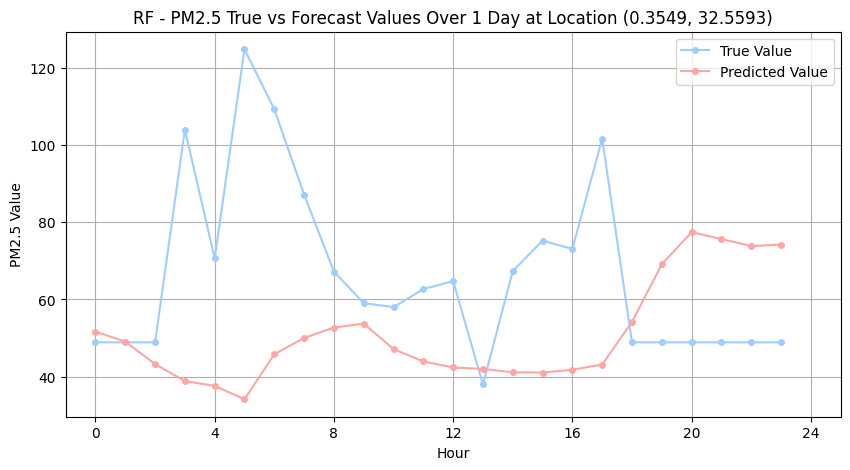

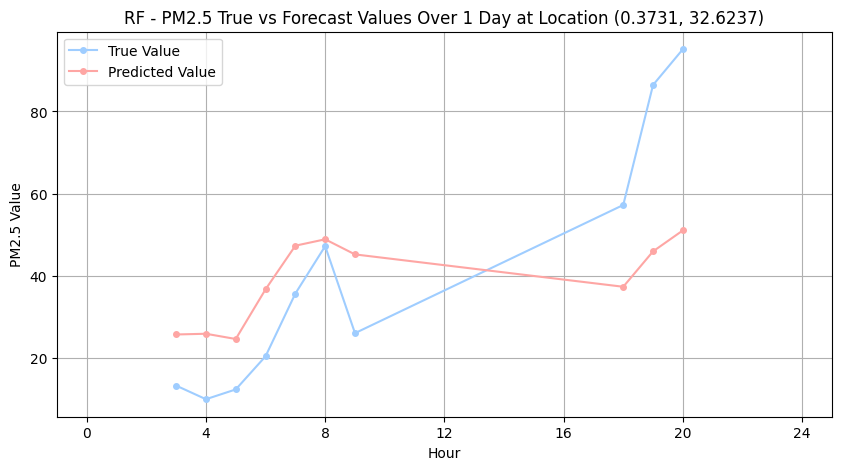

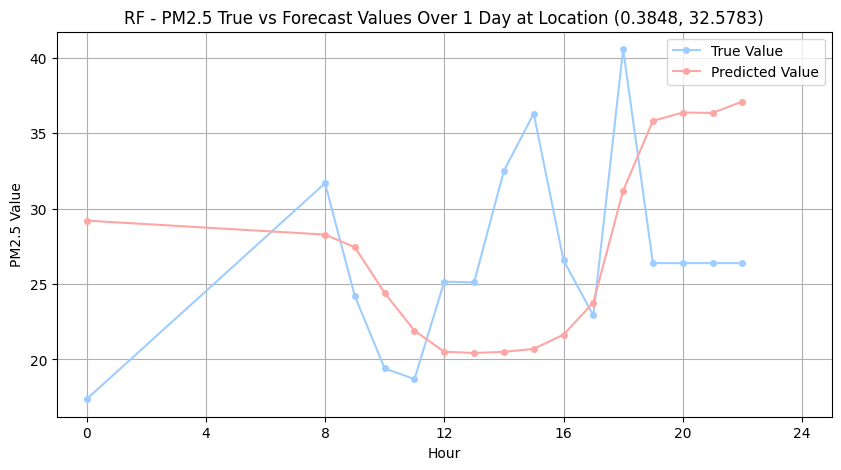

In [62]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

data_test_day['hour'] = data_test_day.index.hour

results = pd.DataFrame()

grouped = data_test_day.groupby(['site_latitude', 'site_longitude', 'hour'])

for (lat, long, hour), group in grouped:
    X = group[features_columns]
    y_true = group[target_column]
    y_pred = random_search_rf.best_estimator_.predict(X)

    temp_df = pd.DataFrame({
        'Latitude': [lat] * len(y_true),
        'Longitude': [long] * len(y_true),
        'Hour': [hour] * len(y_true),
        'True Value': y_true,
        'Predicted Value': y_pred
    })
    results = pd.concat([results, temp_df], ignore_index=True)

for (lat, long), group in results.groupby(['Latitude', 'Longitude']):
    plt.figure(figsize=(10, 5))
    plt.plot(group['Hour'], group['True Value'], label='True Value', marker='o', markersize=4, color='#9FCDFF')
    plt.plot(group['Hour'], group['Predicted Value'], label='Predicted Value', marker='o', markersize=4, color='#FEA6A4')
    plt.title(f"RF - PM2.5 True vs Forecast Values Over 1 Day at Location ({lat:.4f}, {long:.4f})")
    plt.xlabel('Hour')
    plt.ylabel('PM2.5 Value')
    plt.xticks([0, 4, 8, 12, 16, 20, 24])
    plt.xlim(-1, 25)
    plt.legend()
    plt.grid(True)
    plt.show()


## For forecast - For 7 days

In [64]:
data_test_day = data_test[(data_test.index.month==12) & (data_test.index.day<=7)]
X_test_day = data_test_day[features_columns]
y_test_day = data_test_day[target_column]
# 预测新的测试数据
y_test_day_pred = random_search_rf.best_estimator_.predict(X_test_day)
test_rmse = np.sqrt(mean_squared_error(y_test_day, y_test_day_pred))
test_mae = mean_absolute_error(y_test_day, y_test_day_pred)
test_mape = np.mean(np.abs((y_test_day - y_test_day_pred) / y_test_day)) * 100

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}")


Test RMSE: 12.485028152413918
Test MAE: 8.921952725566289
Test MAPE: 38.22344637769523


C:\Users\DELL\AppData\Local\Temp\ipykernel_27168\830720045.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_day['day'] = data_test_day.index.day
C:\Users\DELL\AppData\Local\Temp\ipykernel_27168\830720045.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_day['hour'] = (data_test_day['day'] - data_test_day['day'].min()) * 24 + data_test_day.index.hour


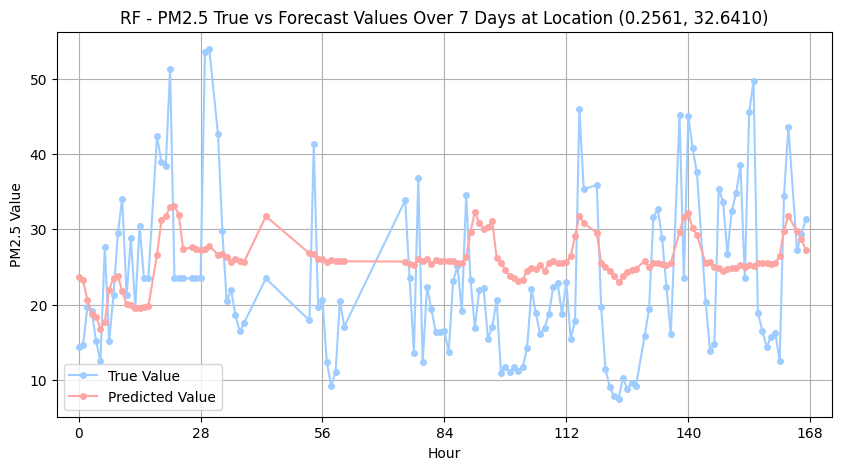

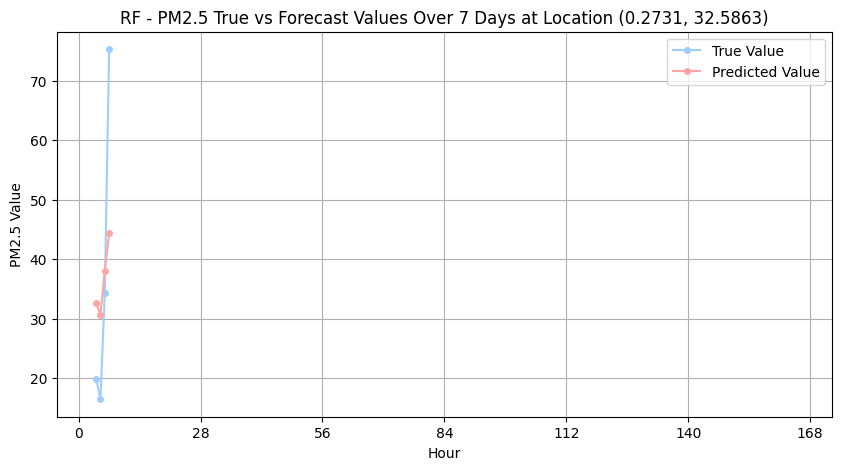

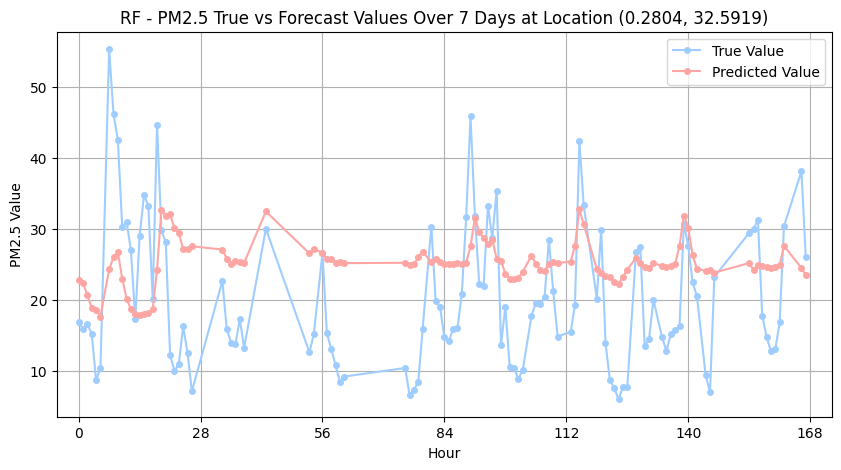

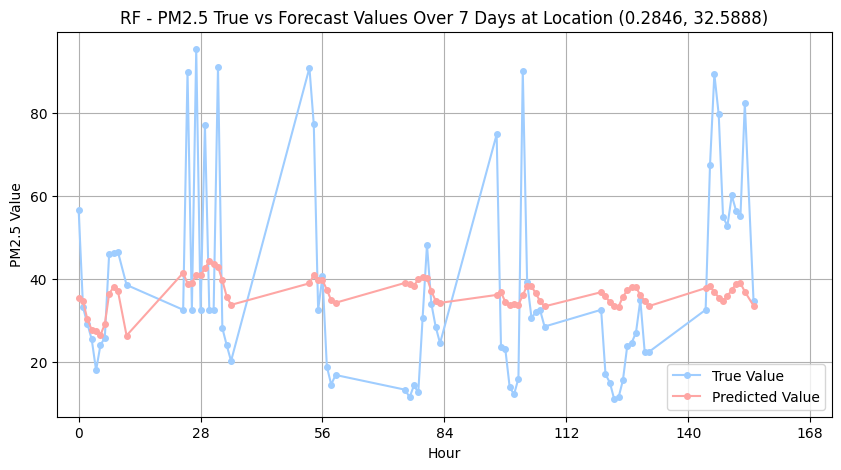

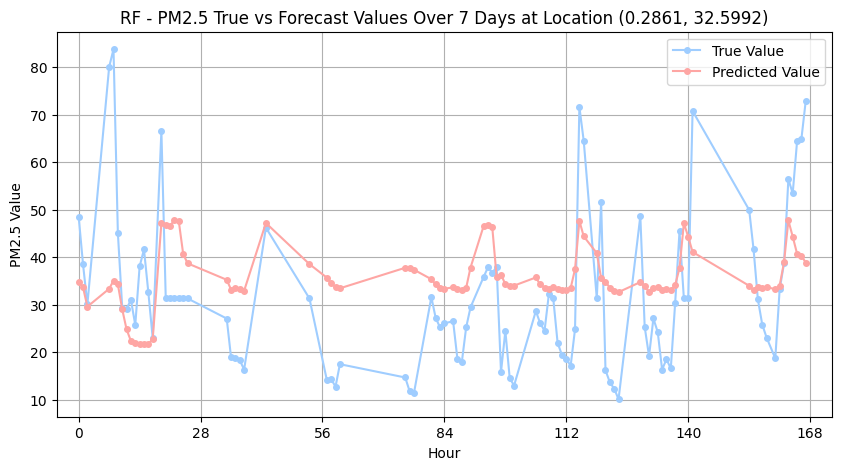

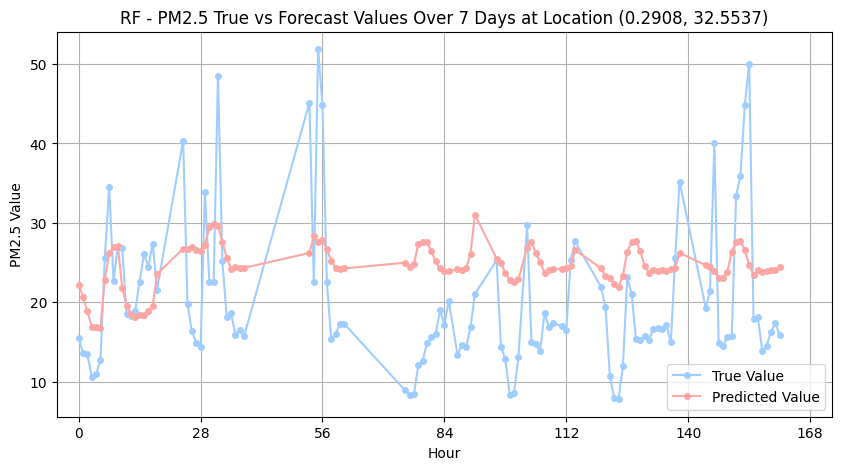

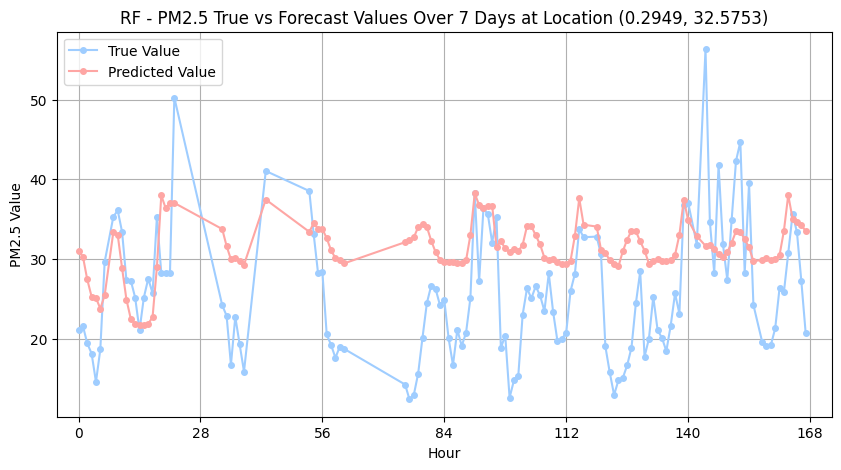

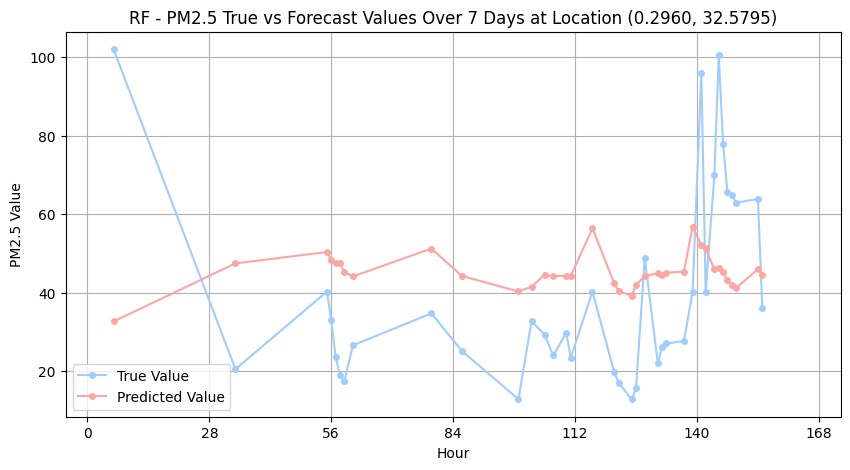

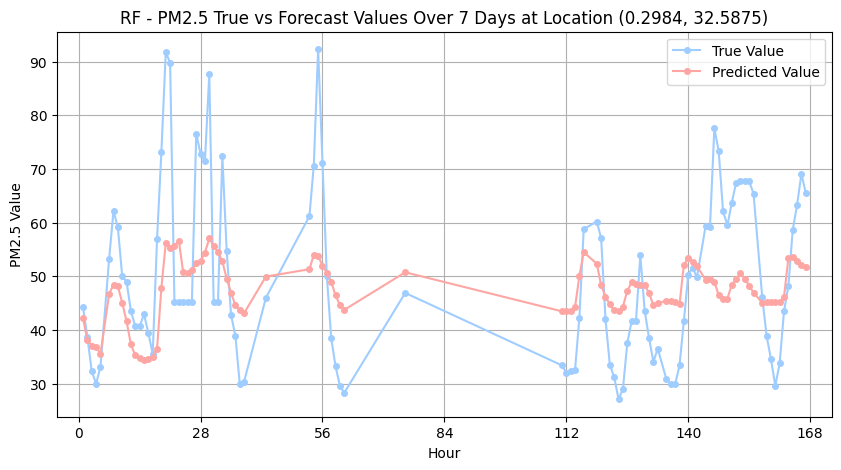

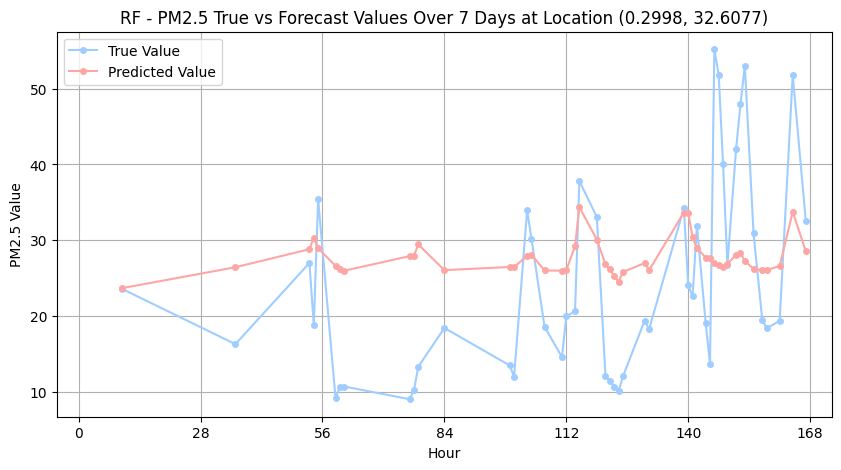

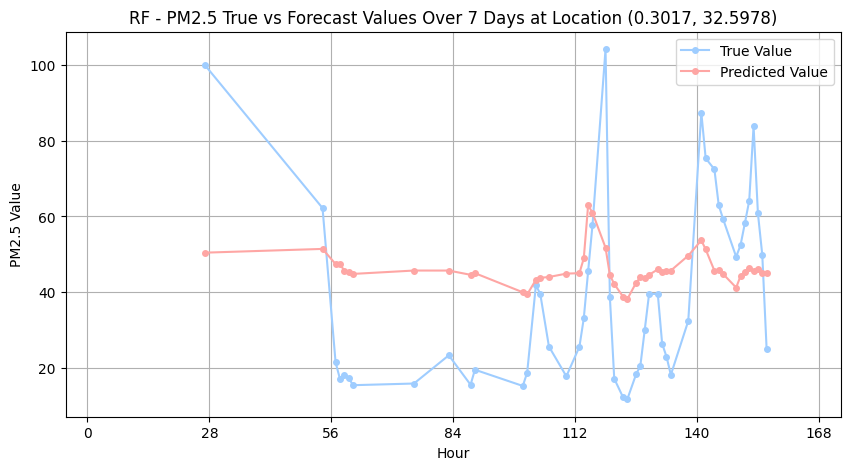

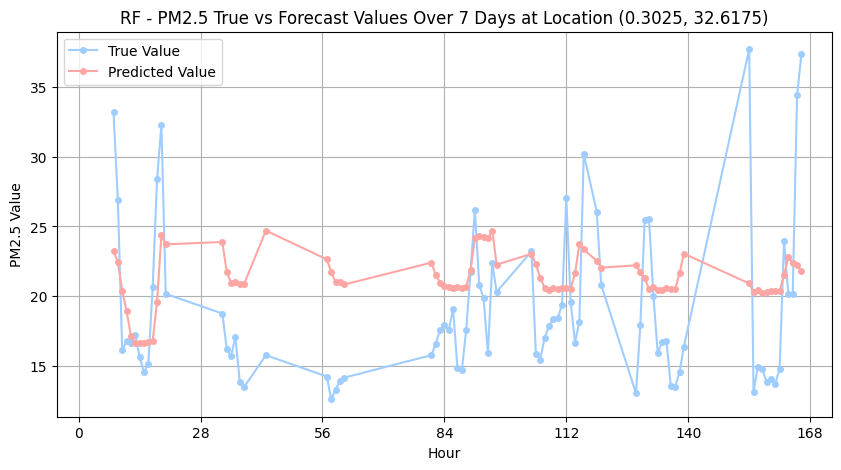

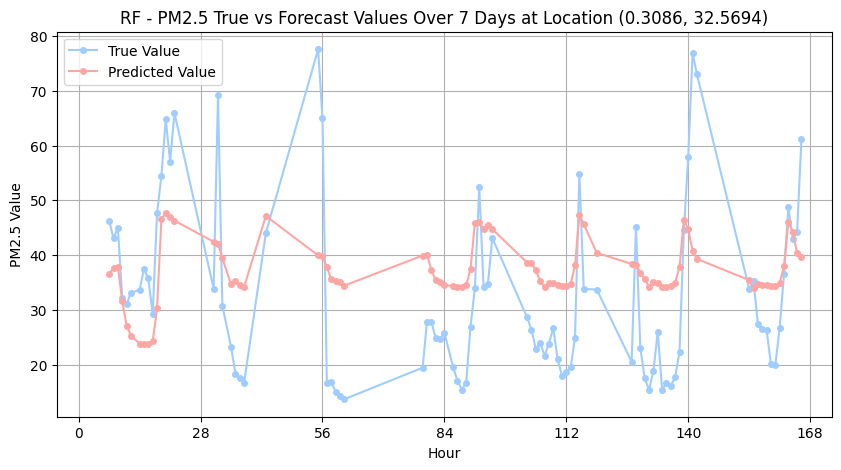

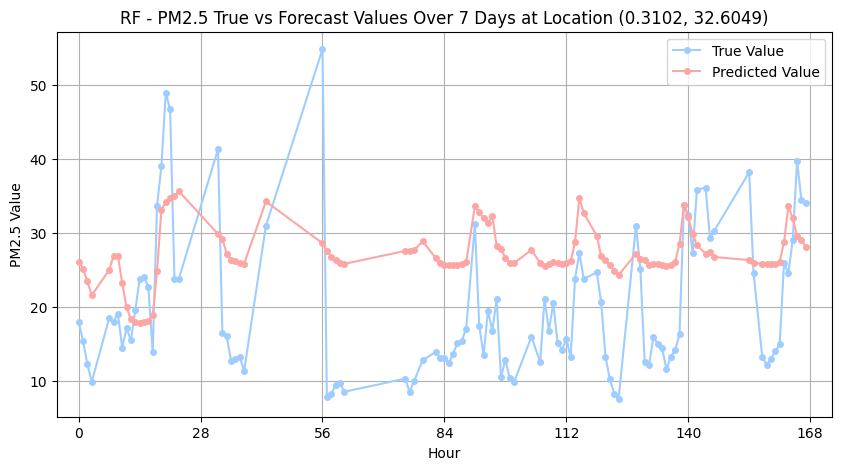

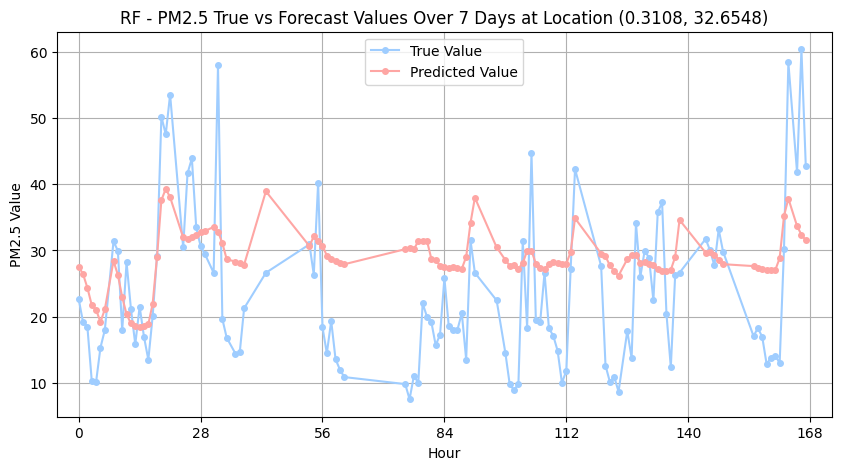

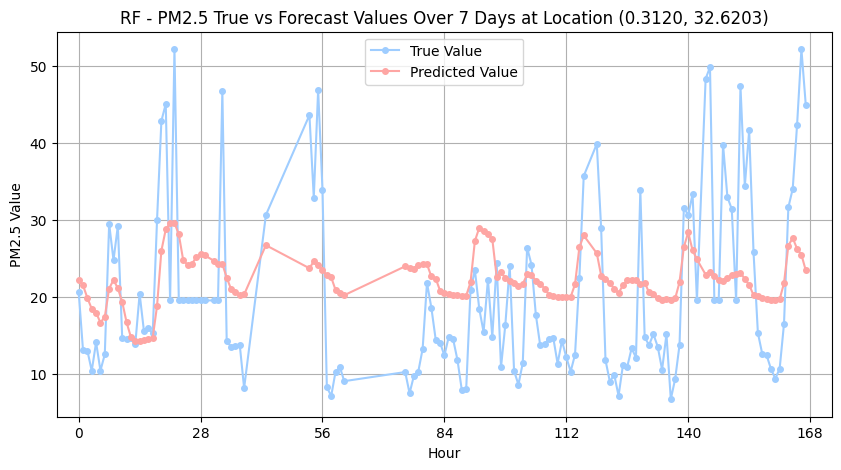

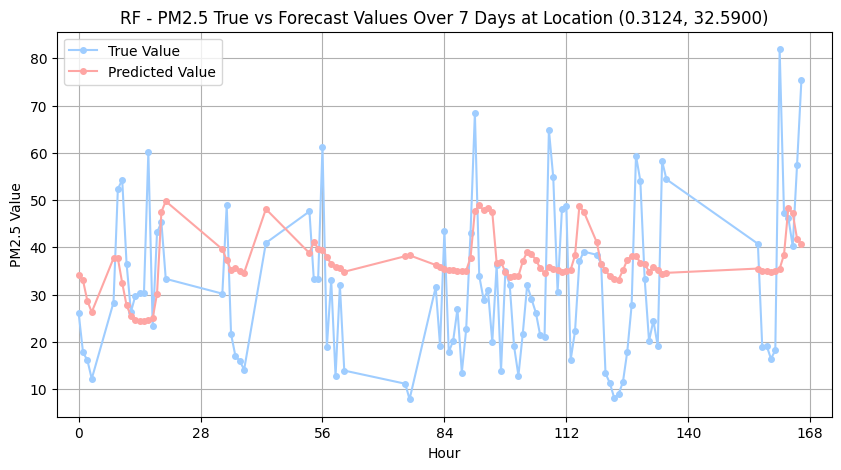

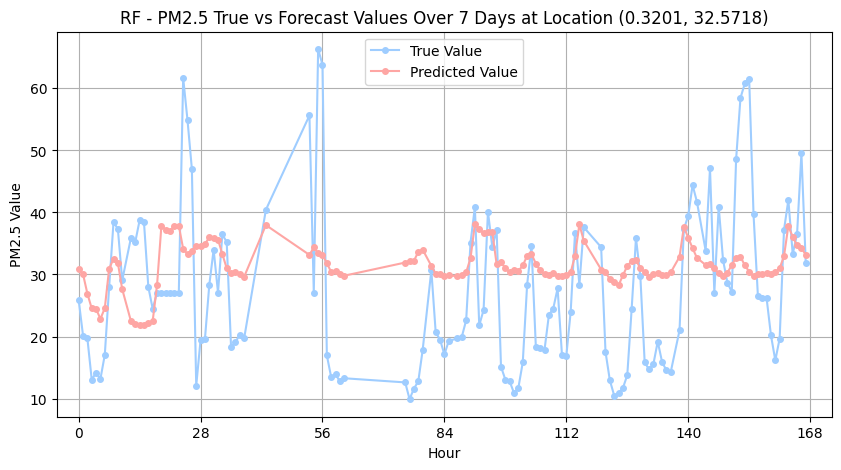

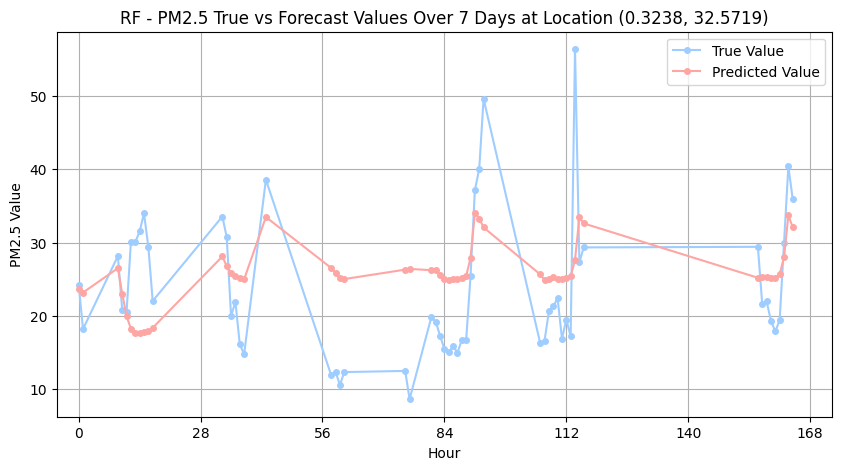

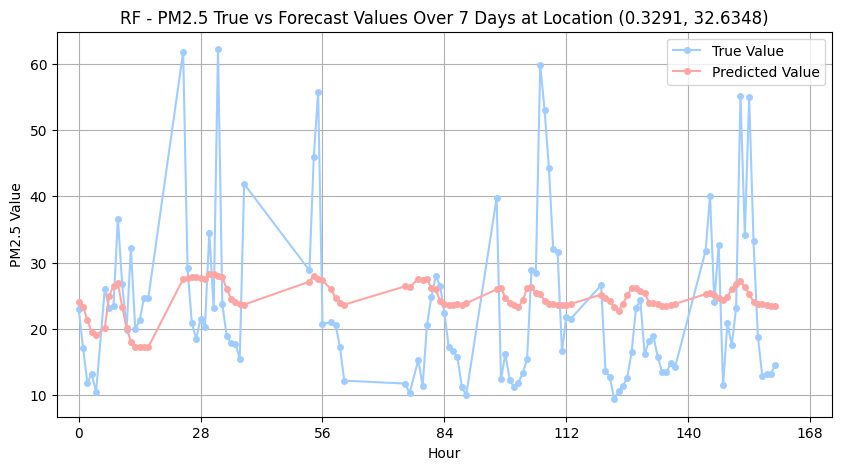

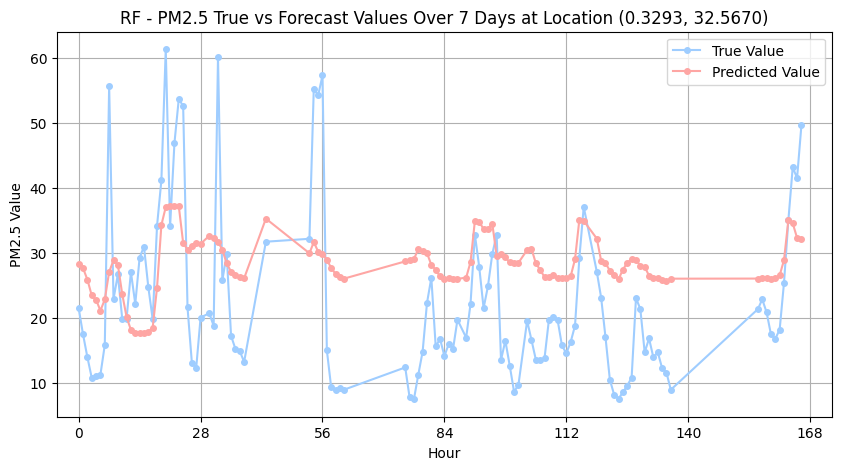

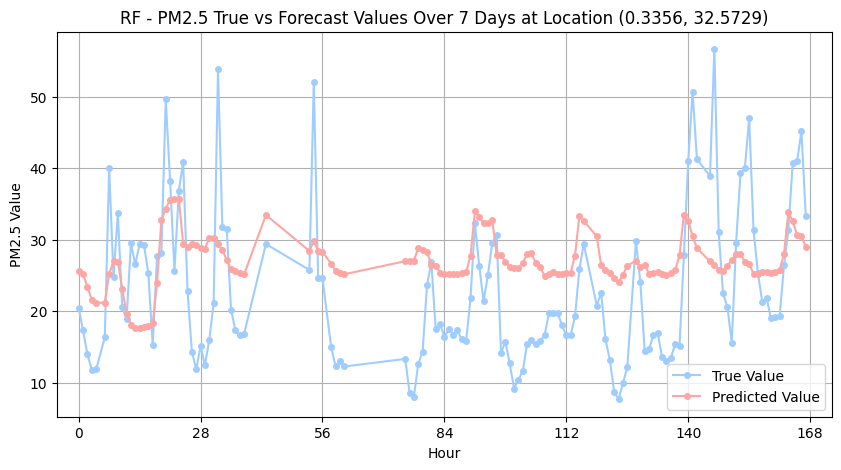

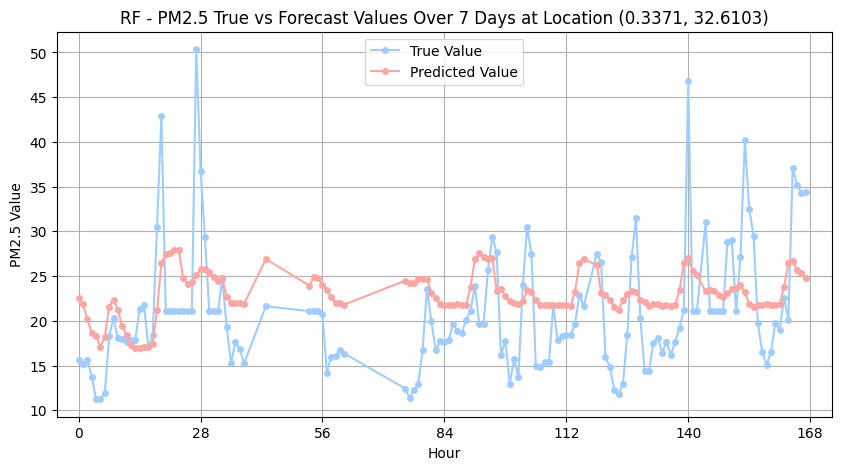

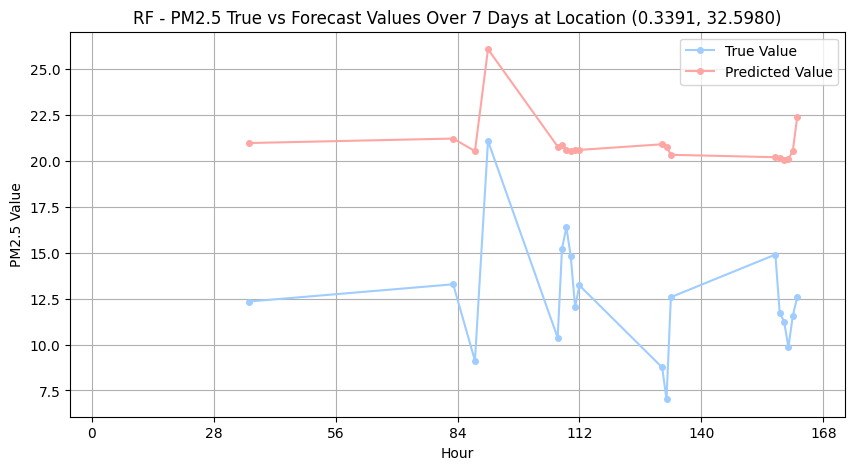

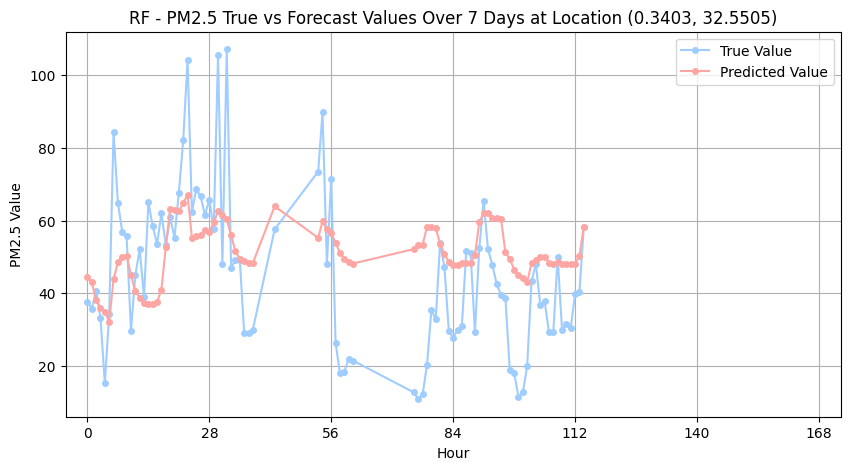

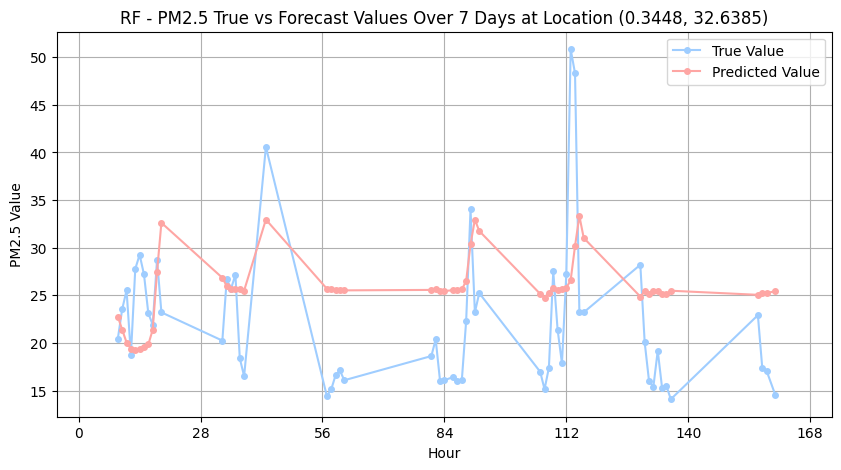

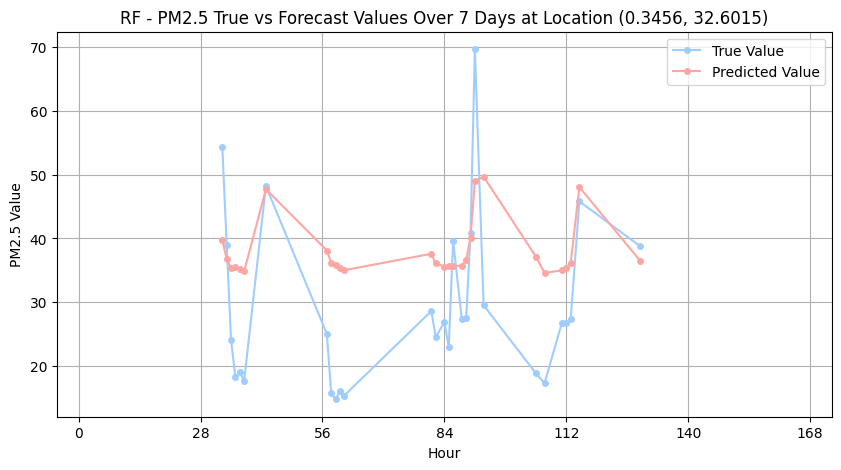

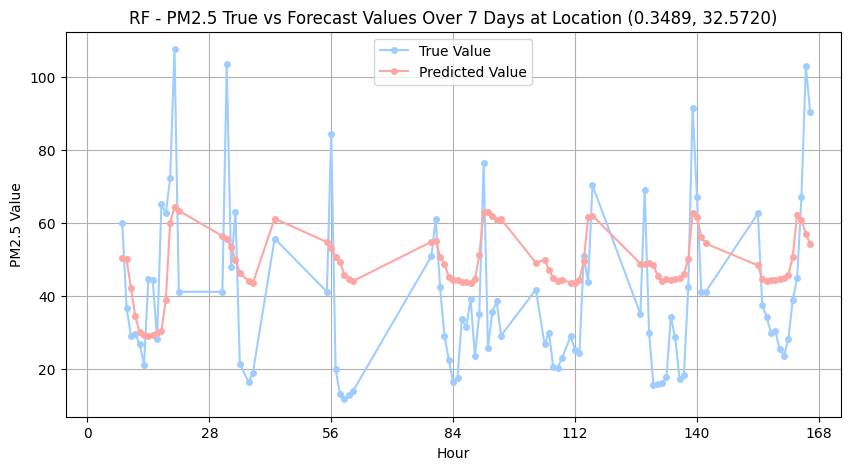

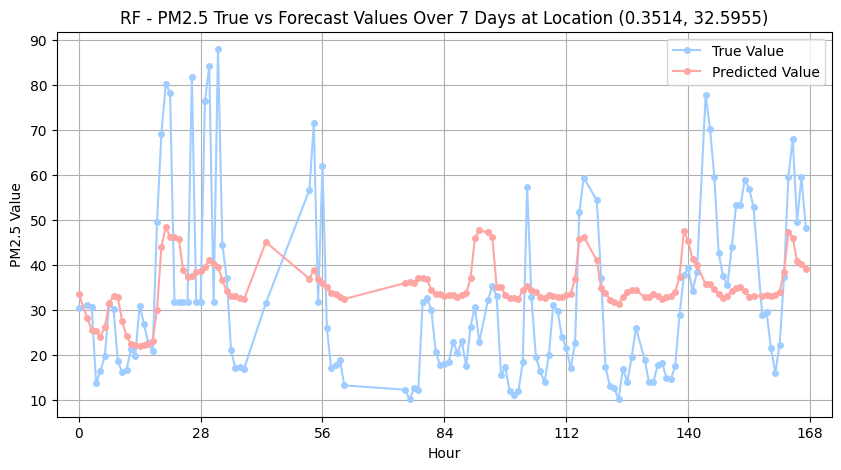

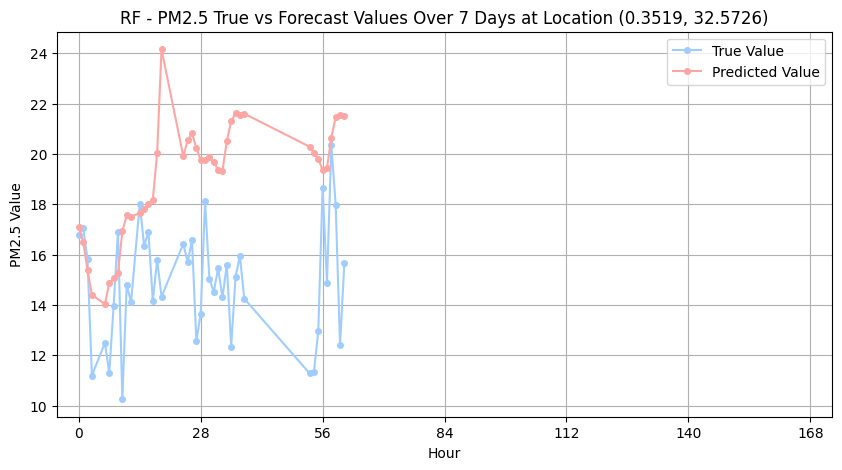

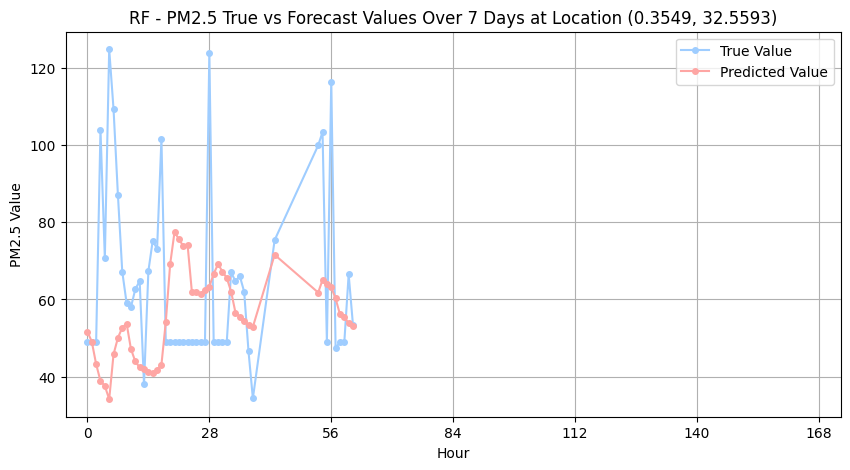

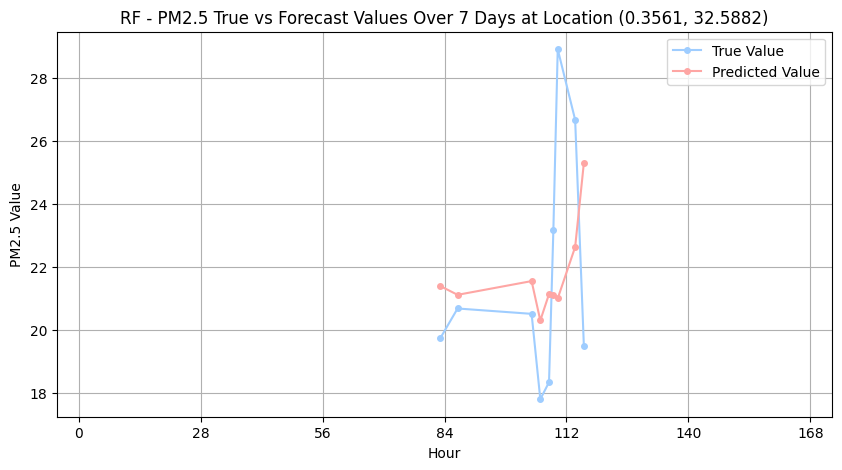

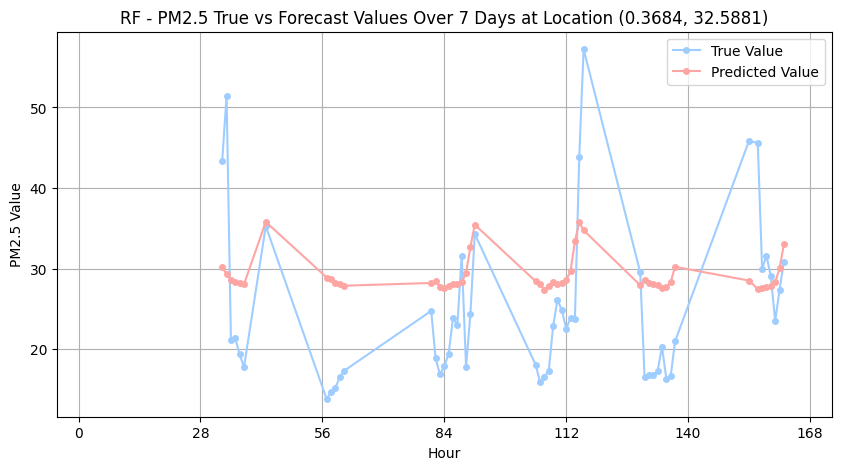

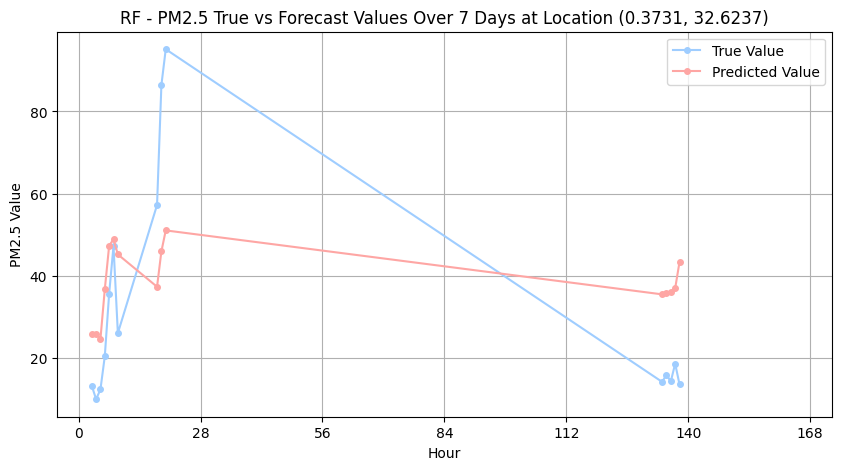

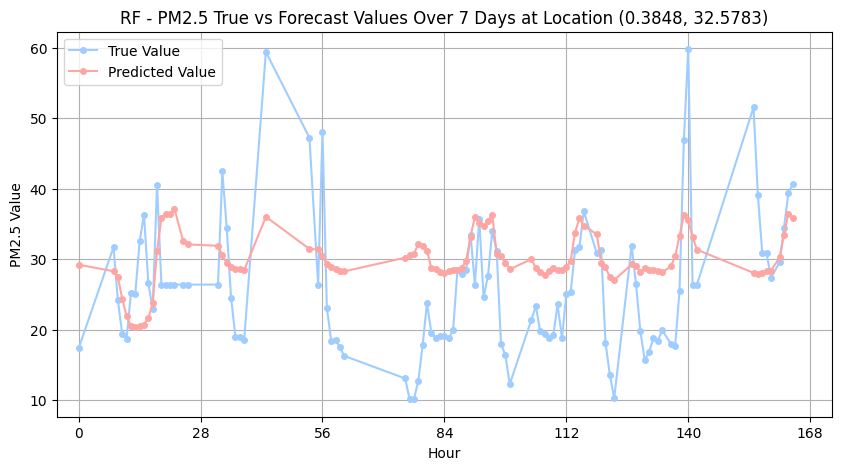

In [65]:
results = pd.DataFrame()
data_test_day['day'] = data_test_day.index.day
data_test_day['hour'] = (data_test_day['day'] - data_test_day['day'].min()) * 24 + data_test_day.index.hour

grouped = data_test_day.groupby(['site_latitude', 'site_longitude', 'hour'])

for (lat, long, hour), group in grouped:
    X = group[features_columns]
    y_true = group[target_column]
    y_pred = random_search_rf.best_estimator_.predict(X)

    temp_df = pd.DataFrame({
        'Latitude': [lat] * len(y_true),
        'Longitude': [long] * len(y_true),
        'Hour': [hour] * len(y_true),
        'True Value': y_true,
        'Predicted Value': y_pred
    })
    results = pd.concat([results, temp_df], ignore_index=True)

for (lat, long), group in results.groupby(['Latitude', 'Longitude']):
    plt.figure(figsize=(10, 5))
    plt.plot(group['Hour'], group['True Value'], label='True Value', marker='o', markersize=4, color='#9FCDFF') 
    plt.plot(group['Hour'], group['Predicted Value'], label='Predicted Value', marker='o', markersize=4, color='#FEA6A4')
    plt.title(f"RF - PM2.5 True vs Forecast Values Over 7 Days at Location ({lat:.4f}, {long:.4f})")
    plt.xlabel('Hour')
    plt.ylabel('PM2.5 Value')
    plt.xticks(np.arange(0, 169, 28))
    plt.xlim(-5, 173)
    plt.legend()
    plt.grid(True)
    plt.show()


## For forecast - For 30 days

In [66]:
data_test_day = data_test[(data_test.index.month==12) & (data_test.index.day<=30)]
X_test_day = data_test_day[features_columns]
y_test_day = data_test_day[target_column]

y_test_day_pred = random_search_rf.best_estimator_.predict(X_test_day)

test_rmse = np.sqrt(mean_squared_error(y_test_day, y_test_day_pred))
test_mae = mean_absolute_error(y_test_day, y_test_day_pred)
test_mape = np.mean(np.abs((y_test_day - y_test_day_pred) / y_test_day)) * 100

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape}")


Test RMSE: 15.557870397101658
Test MAE: 11.186016426048102
Test MAPE: 38.35897792906963


C:\Users\DELL\AppData\Local\Temp\ipykernel_27168\1746409288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_day['day'] = data_test_day.index.day
C:\Users\DELL\AppData\Local\Temp\ipykernel_27168\1746409288.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_day['hour'] = (data_test_day['day'] - data_test_day['day'].min()) * 24 + data_test_day.index.hour


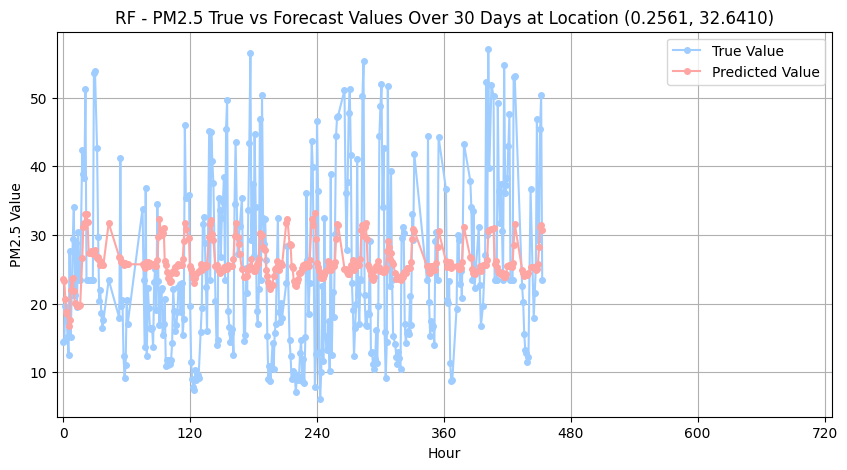

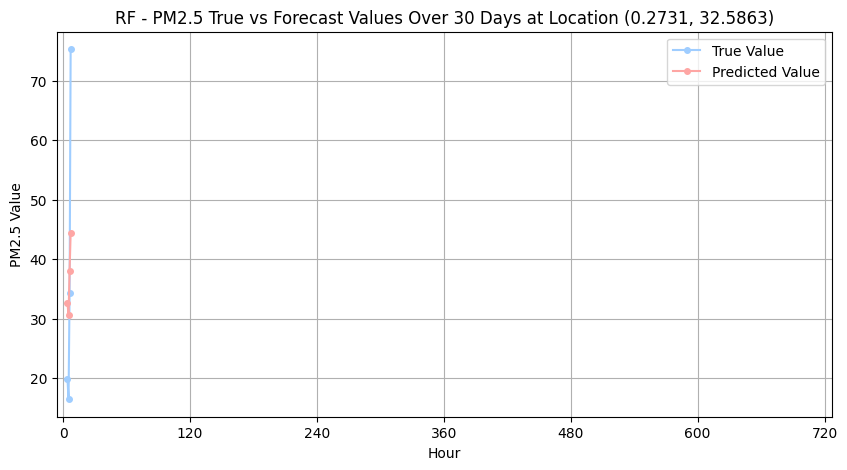

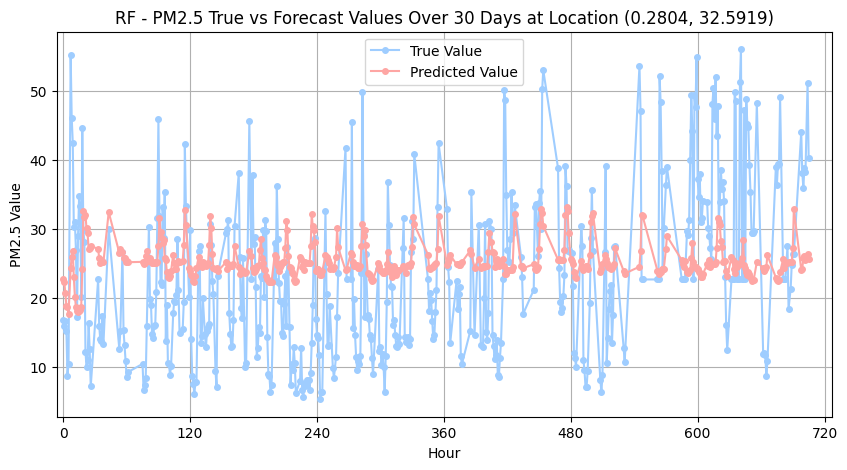

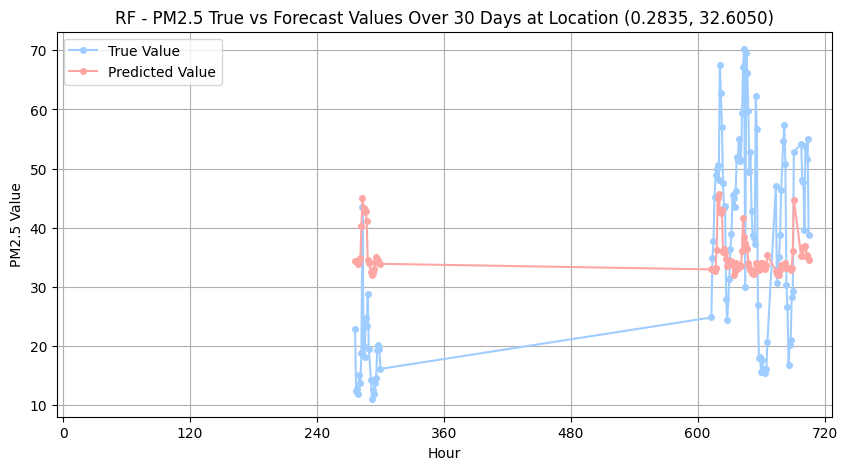

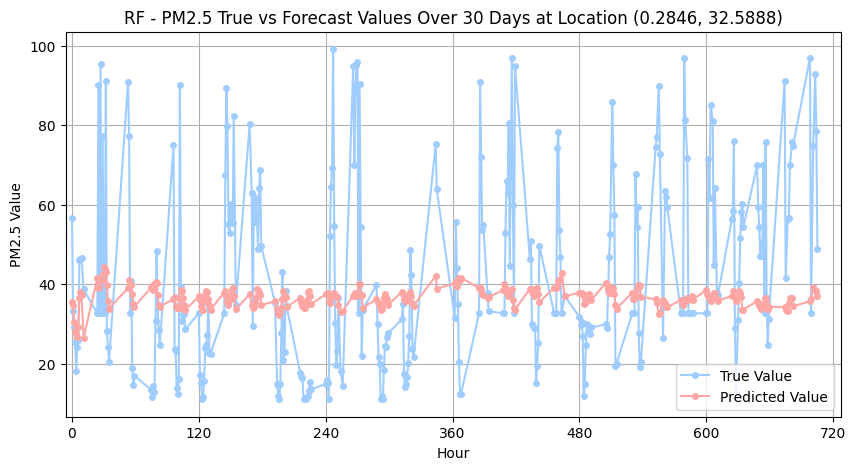

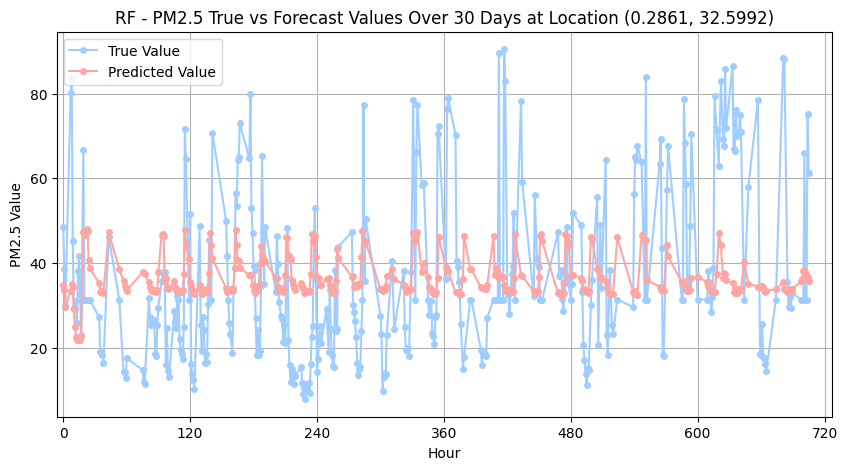

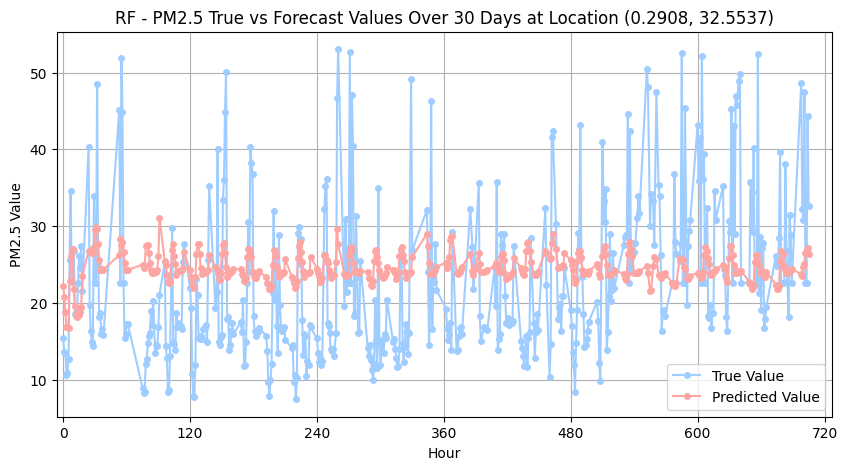

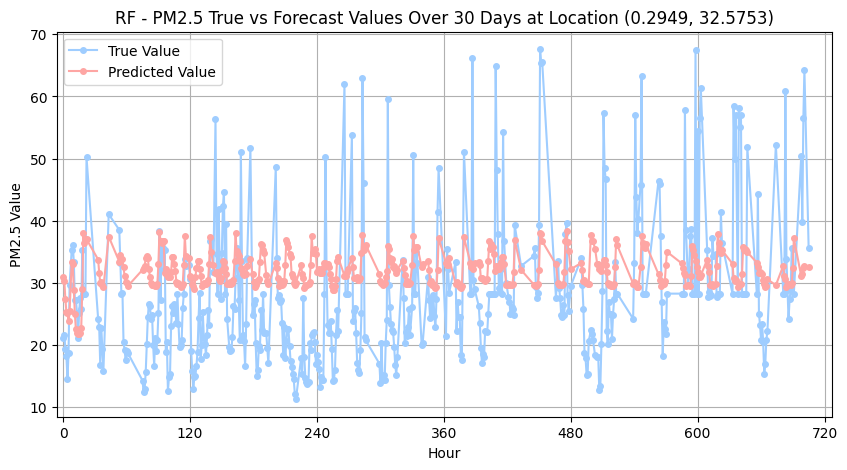

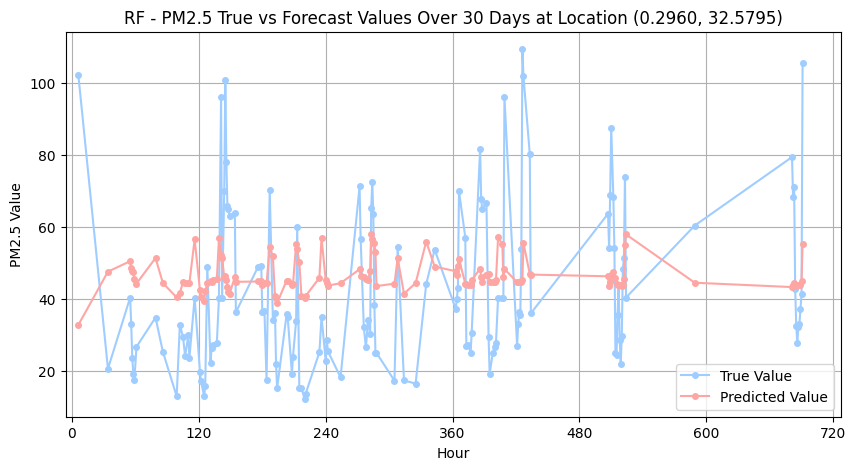

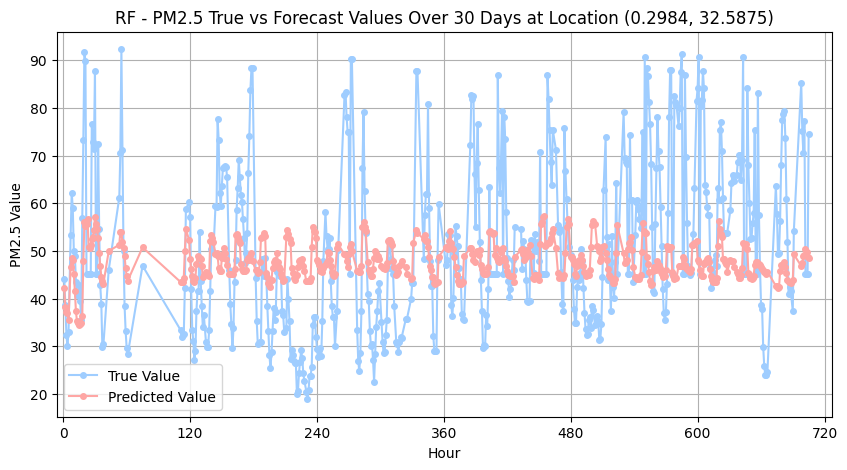

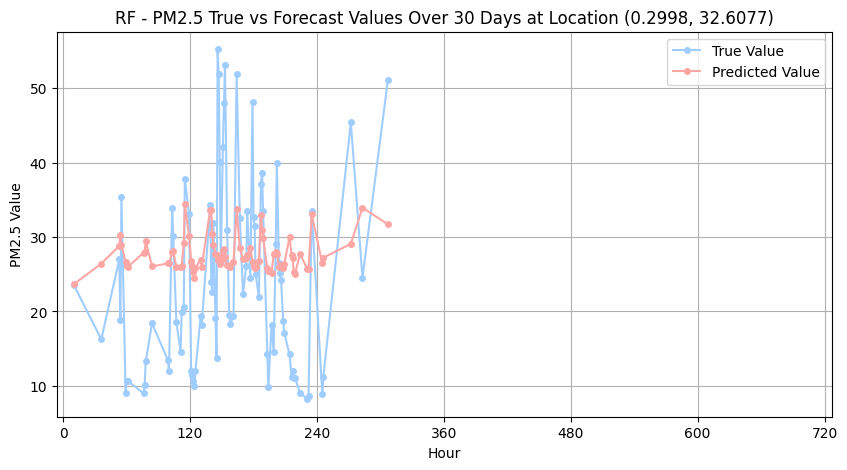

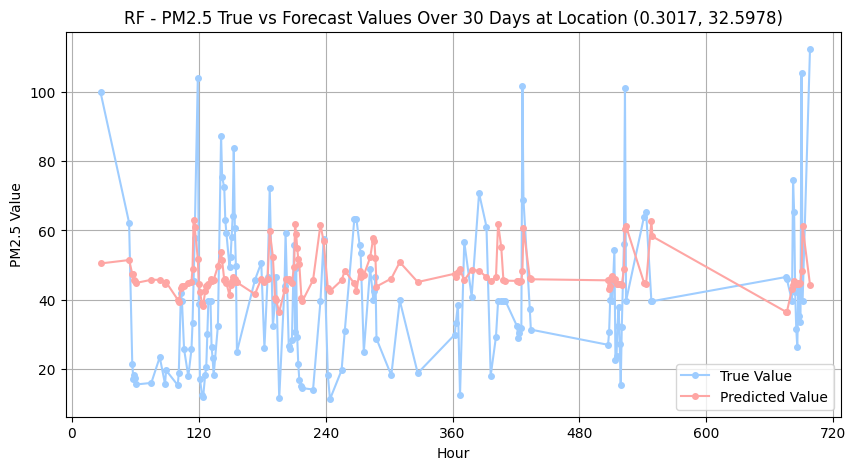

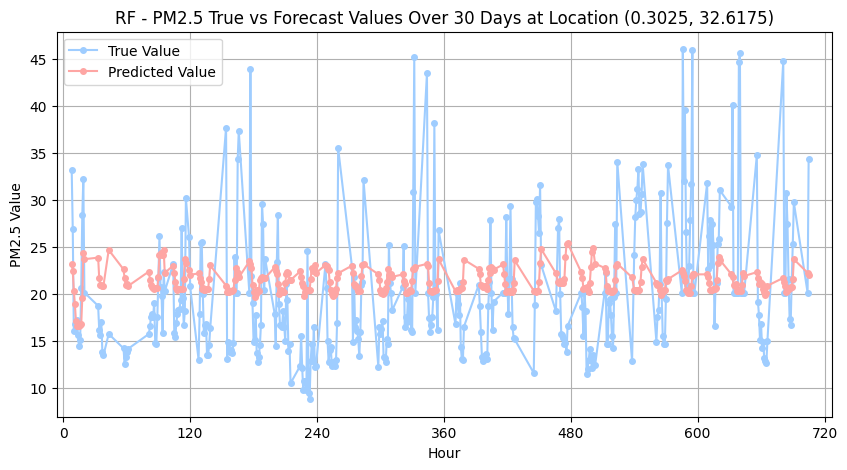

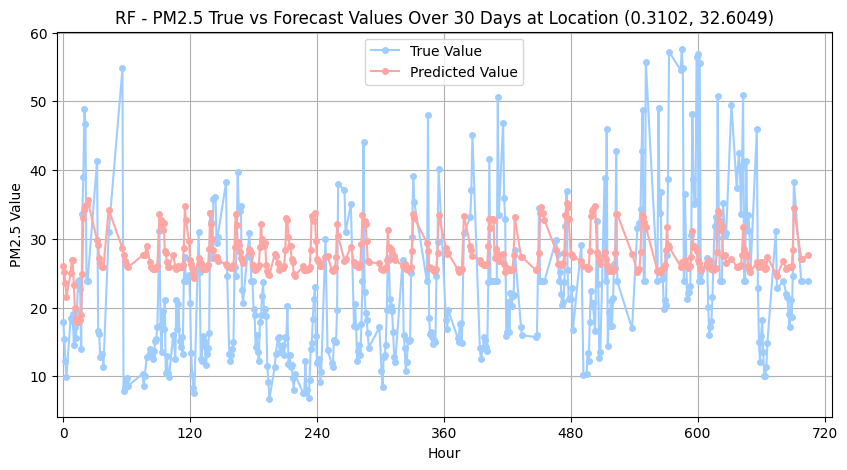

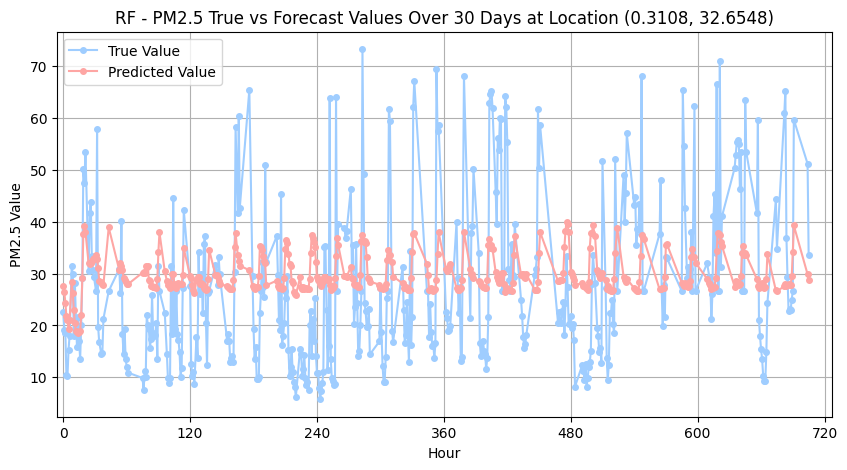

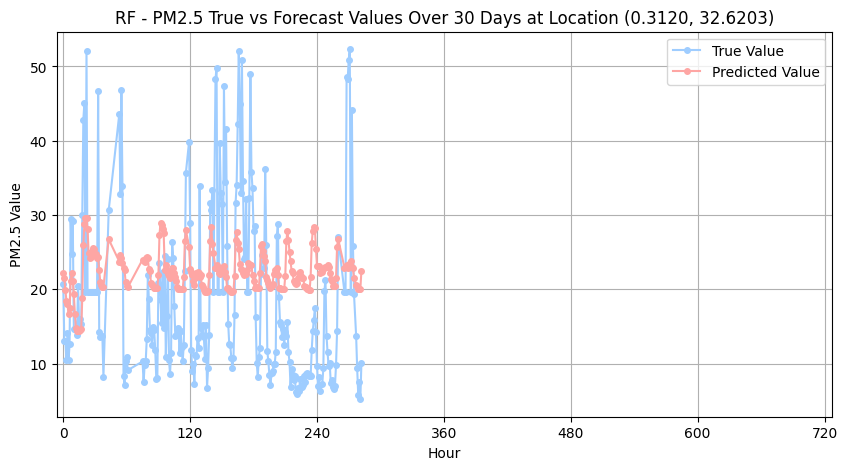

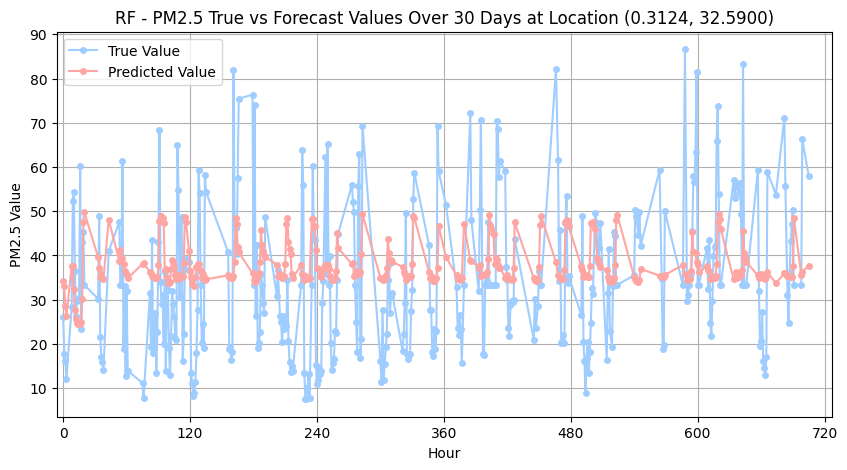

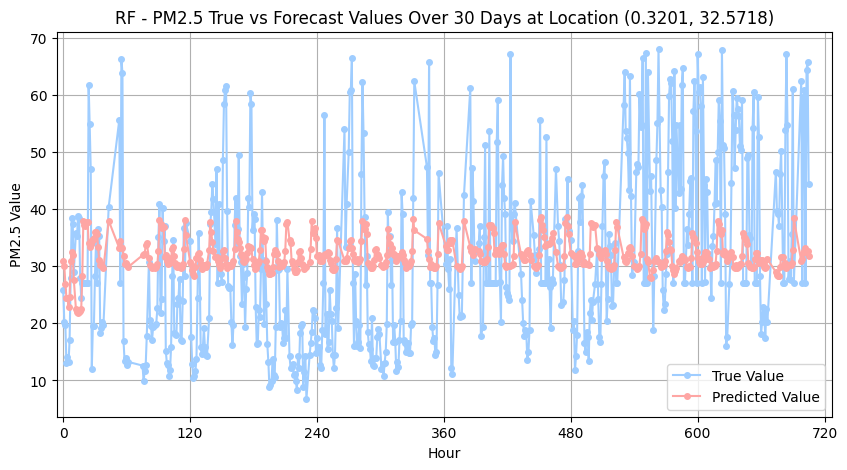

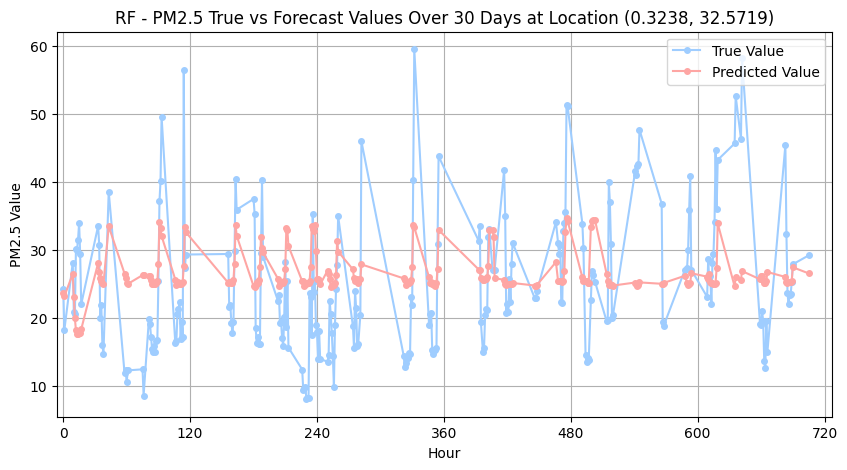

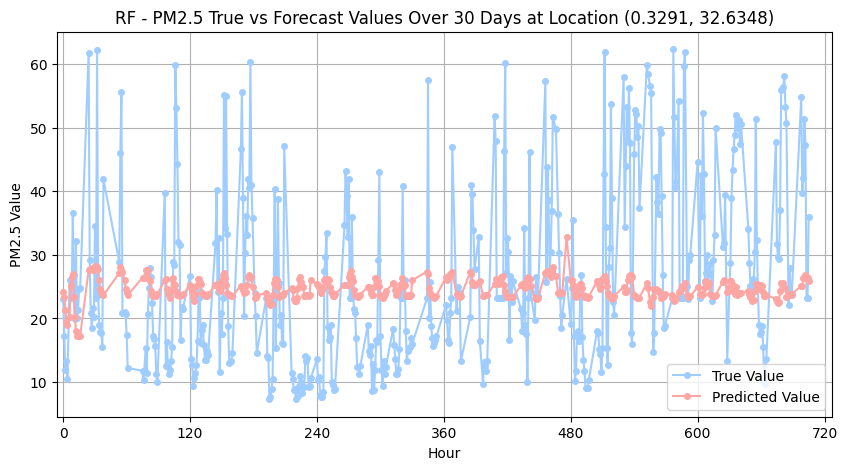

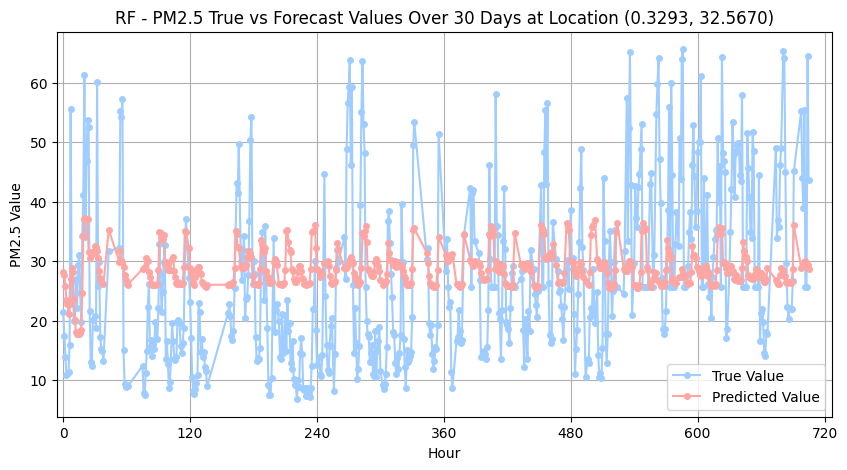

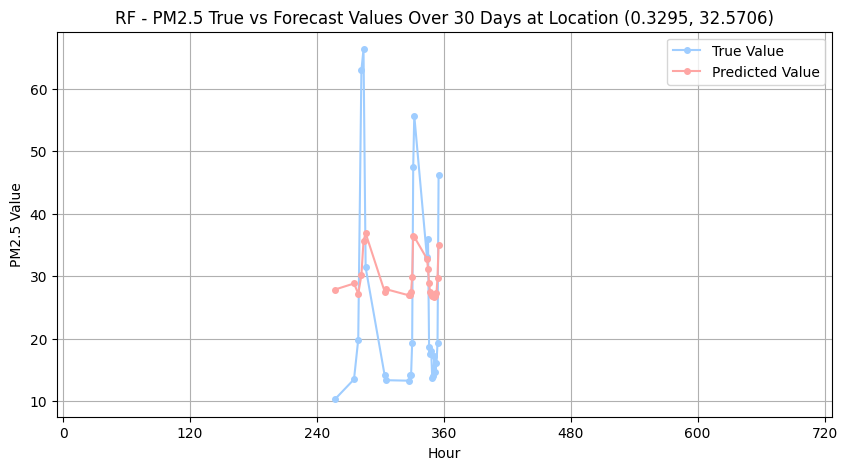

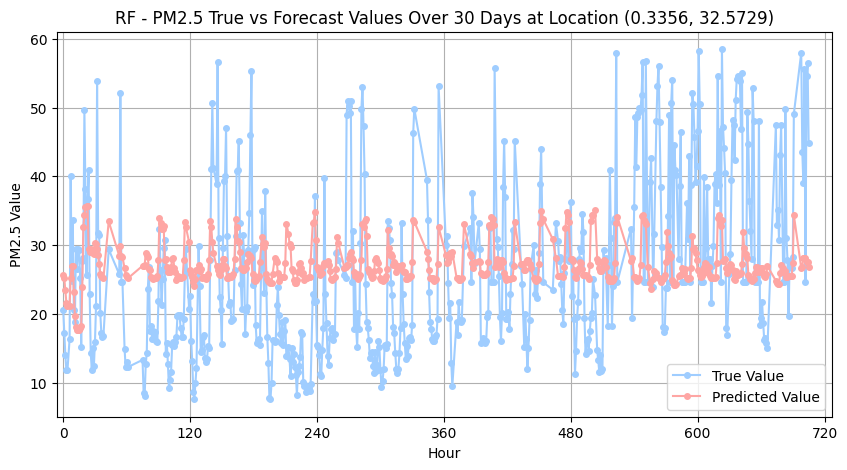

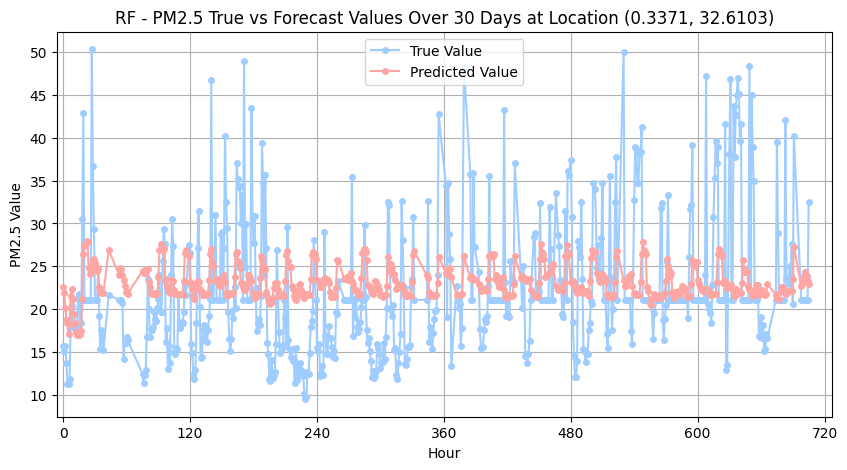

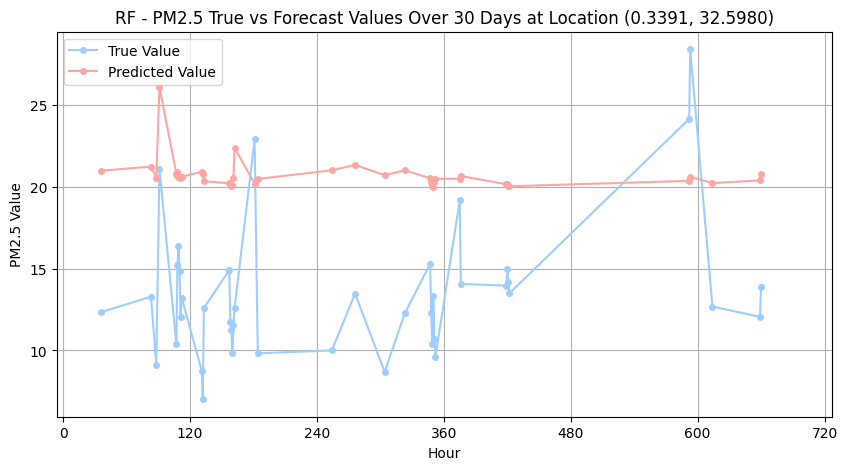

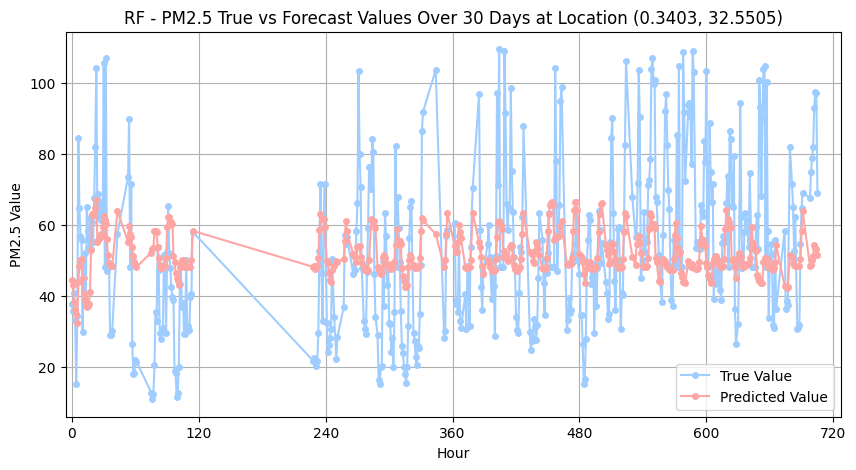

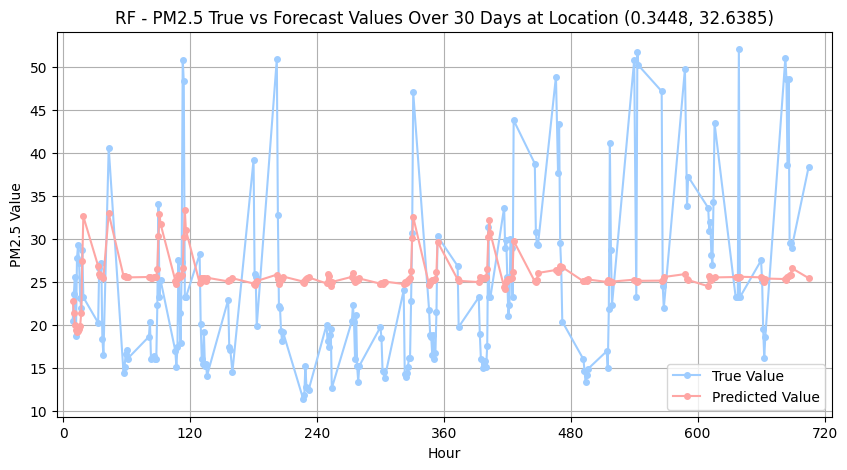

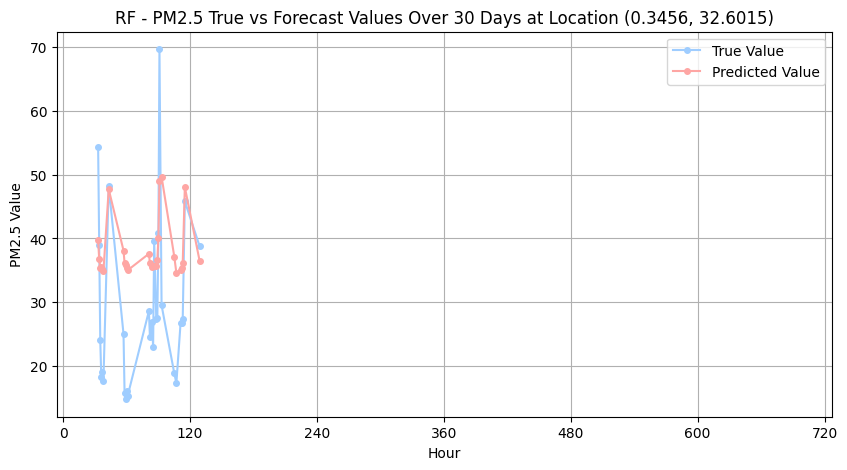

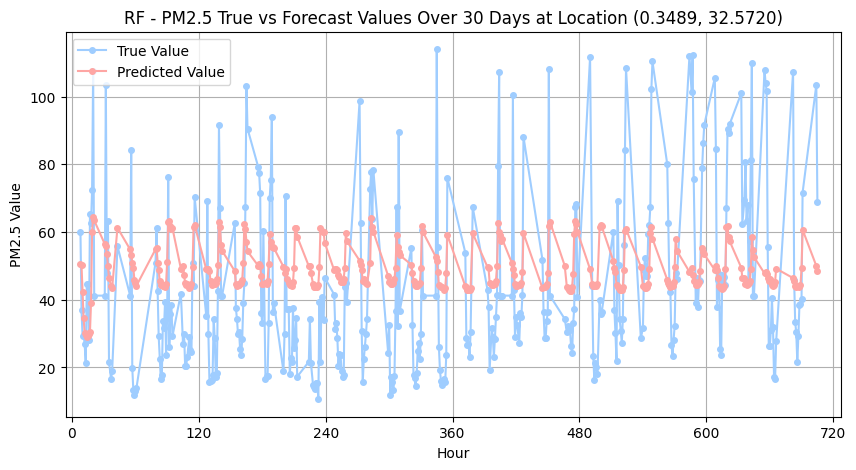

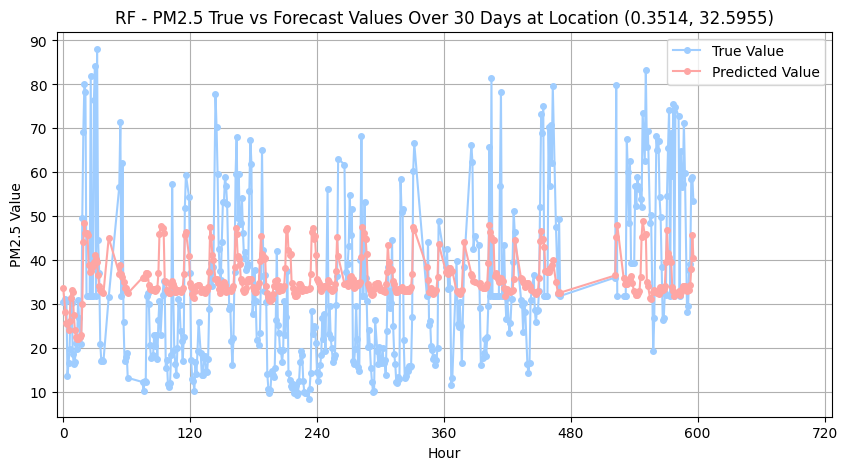

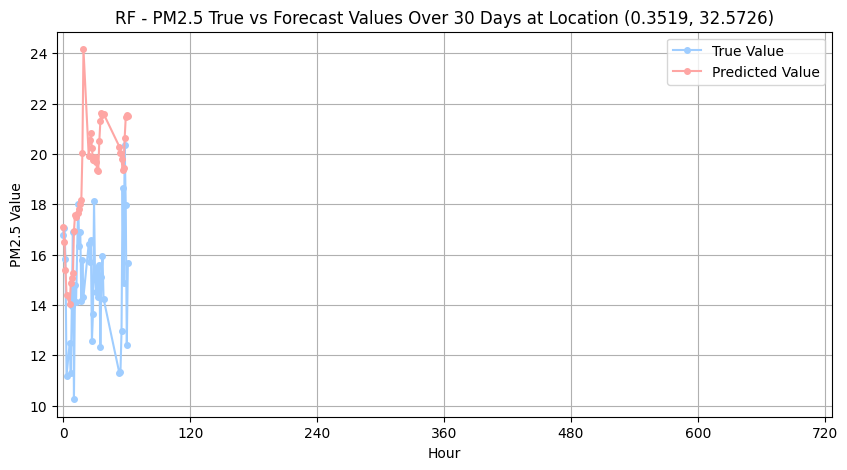

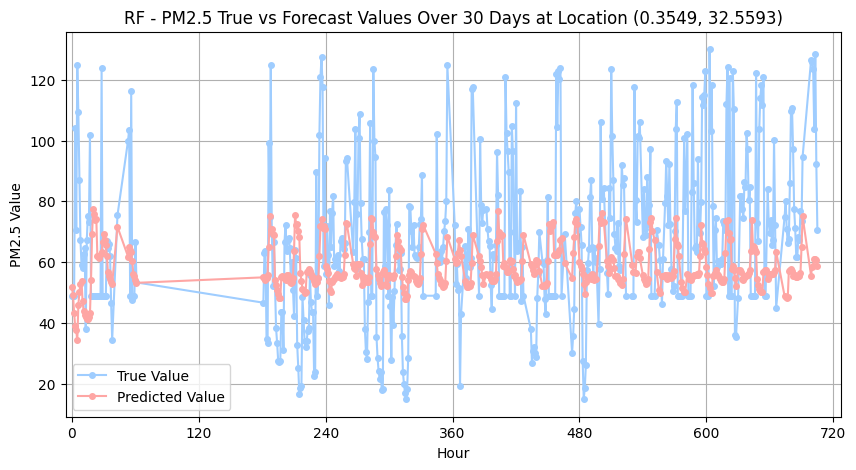

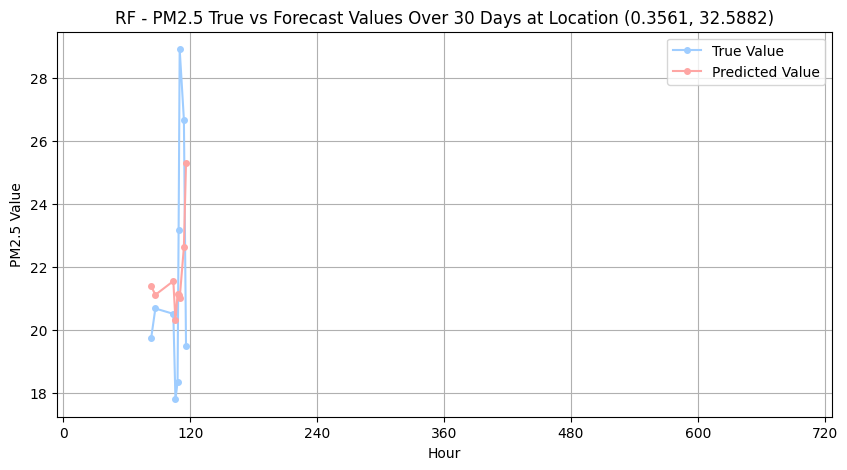

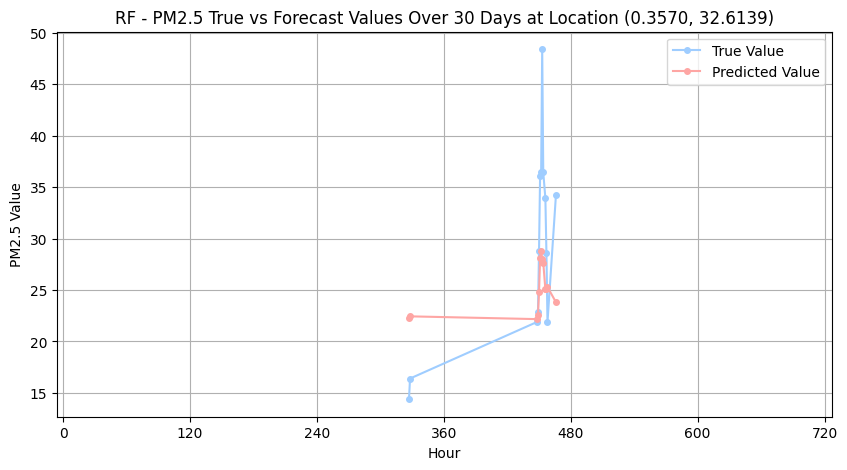

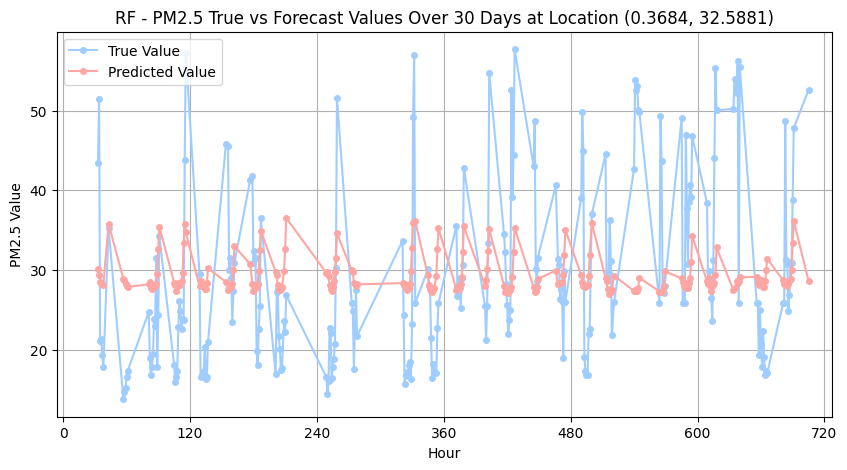

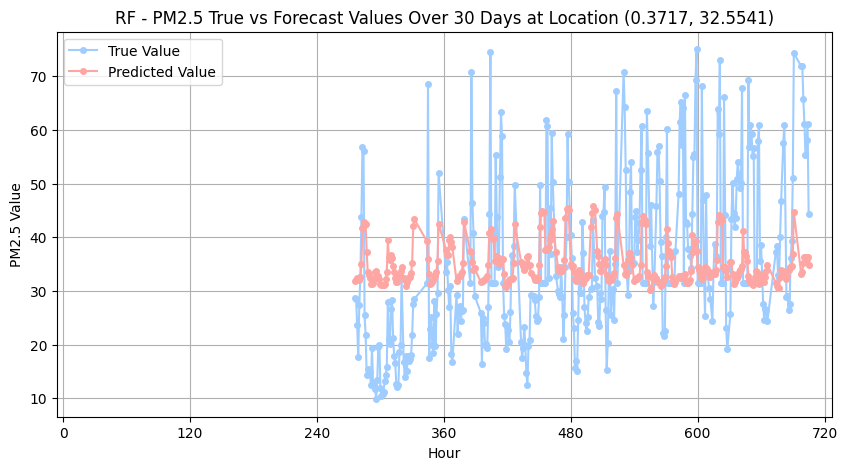

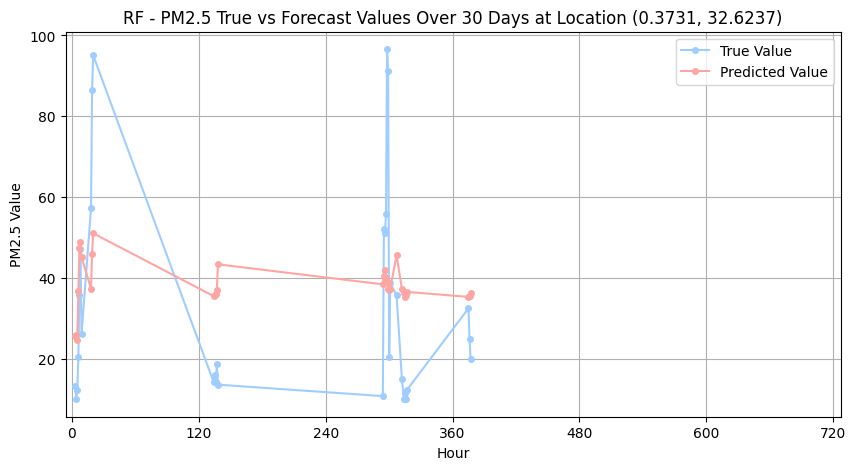

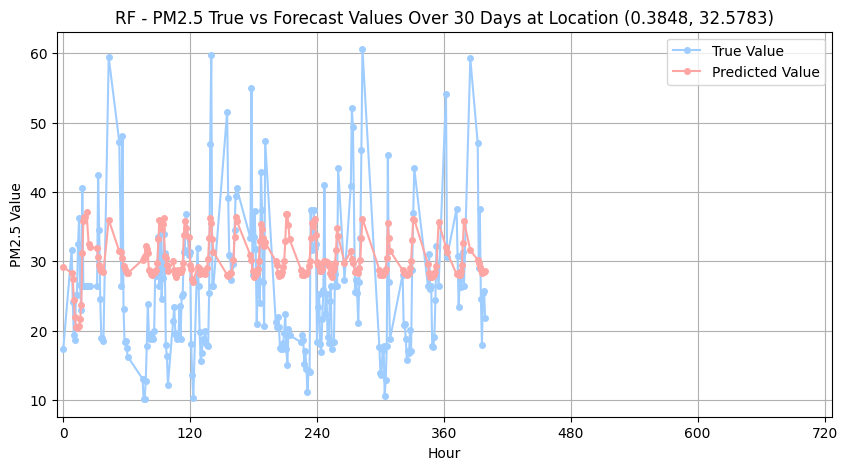

In [67]:
results = pd.DataFrame()

data_test_day['day'] = data_test_day.index.day
data_test_day['hour'] = (data_test_day['day'] - data_test_day['day'].min()) * 24 + data_test_day.index.hour

grouped = data_test_day.groupby(['site_latitude', 'site_longitude', 'hour'])

for (lat, long, hour), group in grouped:
    X = group[features_columns]
    y_true = group[target_column]
    y_pred = random_search_rf.best_estimator_.predict(X)

    temp_df = pd.DataFrame({
        'Latitude': [lat] * len(y_true),
        'Longitude': [long] * len(y_true),
        'Hour': [hour] * len(y_true),
        'True Value': y_true,
        'Predicted Value': y_pred
    })
    results = pd.concat([results, temp_df], ignore_index=True)


for (lat, long), group in results.groupby(['Latitude', 'Longitude']):
    plt.figure(figsize=(10, 5))
    plt.plot(group['Hour'], group['True Value'], label='True Value', marker='o', markersize=4, color='#9FCDFF')
    plt.plot(group['Hour'], group['Predicted Value'], label='Predicted Value', marker='o', markersize=4, color='#FEA6A4')
    plt.title(f"RF - PM2.5 True vs Forecast Values Over 30 Days at Location ({lat:.4f}, {long:.4f})")
    plt.xlabel('Hour')
    plt.ylabel('PM2.5 Value')
    plt.xticks(np.arange(0, 721, 120))
    plt.xlim(-6, 727)
    plt.legend()
    plt.grid(True)
    plt.show()
